# P-219, Hourly Energy Consumption Forecast 

PJM Hourly Energy Consumption Data
PJM Interconnection LLC (PJM) is a regional transmission organization (RTO) in the United States. It is part of the Eastern Interconnection grid operating an electric transmission system serving all or parts of Delaware, Illinois, Indiana, Kentucky, Maryland, Michigan, New Jersey, North Carolina, Ohio, Pennsylvania, Tennessee, Virginia, West Virginia, and the District of Columbia. The hourly power consumption data comes from PJM's website and are in megawatts (MW). The regions have changed over the years so data may only appear for certain dates per region.

● Split the last year into a test set- can you build a model to predict energy consumption? ● Find trends in energy consumption around hours of the day, holidays, or long term trends? ● Understand how daily trends change depending of the time of year. Summer trends are very different than winter trends. ● Forecast for next 30 days.


#### Import the libraries

In [119]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np # linear algebra
import warnings
import itertools
import statsmodels.api as sm

# Plotly is a graphing library for interactive, publication-quality graphs
# pip install plotly==4.5.4
import plotly.graph_objects as go                   
import plotly.express as px
from plotly.subplots import make_subplots

from pandas import DataFrame
from numpy import sqrt
import statsmodels.formula.api as smf
from numpy import log
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.graphics.tsaplots as tsa_plots

## 1. Data Collection and Description

In [2]:
df= pd.read_excel("/content/PJMW_MW_Hourly.xlsx")
df.head()

Datetime  PJMW_MW
0 2002-12-31 01:00:00     5077
1 2002-12-31 02:00:00     4939
2 2002-12-31 03:00:00     4885
3 2002-12-31 04:00:00     4857
4 2002-12-31 05:00:00     4930

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143206 entries, 0 to 143205
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   Datetime  143206 non-null  datetime64[ns]
 1   PJMW_MW   143206 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.2 MB


In [4]:
df.describe()

PJMW_MW
count  143206.000000
mean     5602.375089
std       979.142872
min       487.000000
25%      4907.000000
50%      5530.000000
75%      6252.000000
max      9594.000000

## NULL Values

In [5]:
df.isnull().sum()

Datetime    0
PJMW_MW     0
dtype: int64

<Axes: >

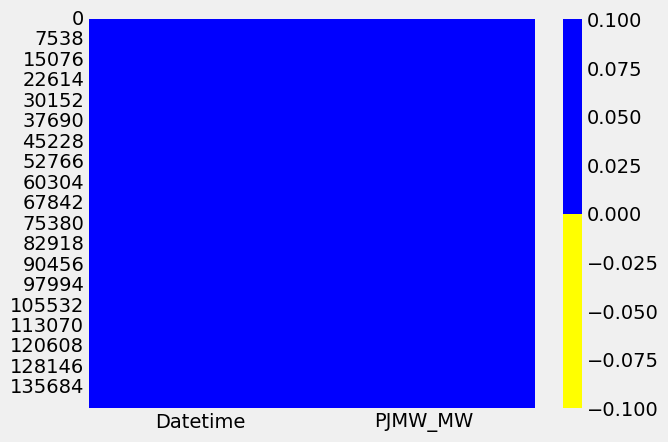

In [6]:
col = df.columns
colours=['yellow','blue']
sns.heatmap(df.isnull(),cmap=sns.color_palette(colours))

In [7]:
df.duplicated().sum()

0

### There are no null values and duplicated values present in the data

# Plotting the whole data
## Line Plot

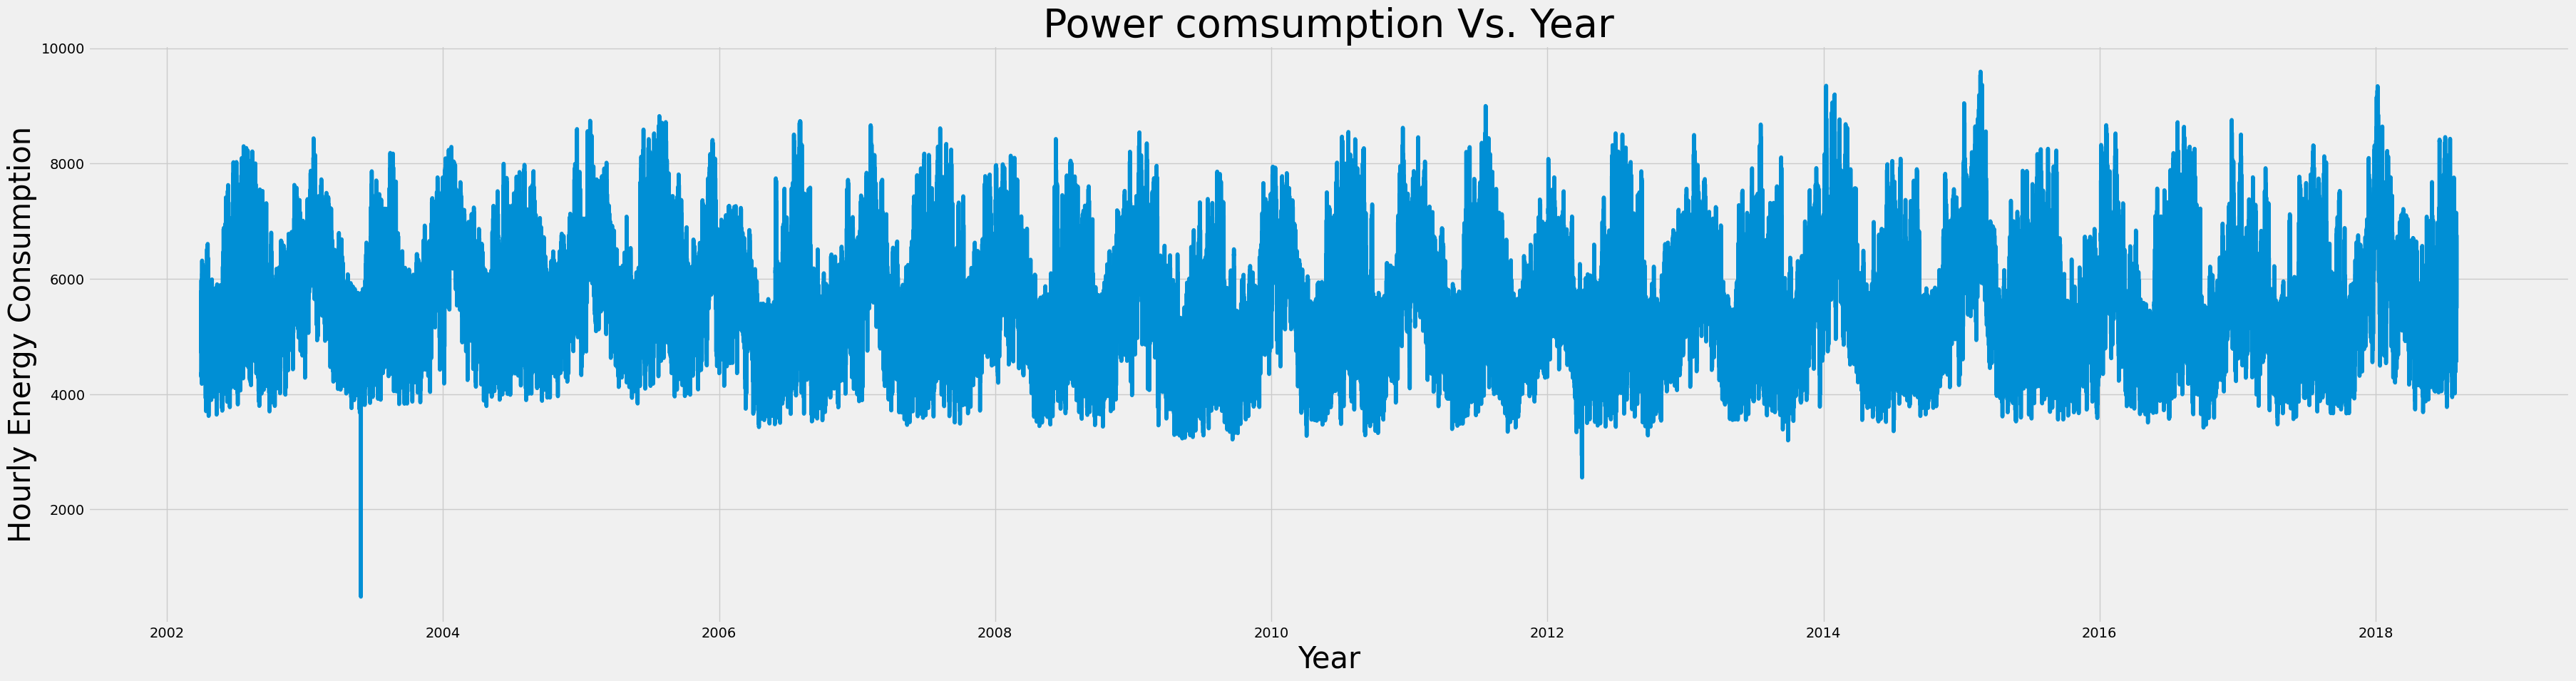

In [8]:
#Line plot
plt.figure(figsize=(40,10))
sns.lineplot(y='PJMW_MW',x='Datetime',data=df);
plt.title('Power comsumption Vs. Year',fontsize=40);
plt.xlabel('Year',fontsize=30);
plt.ylabel('Hourly Energy Consumption',fontsize=30);

## Histogram

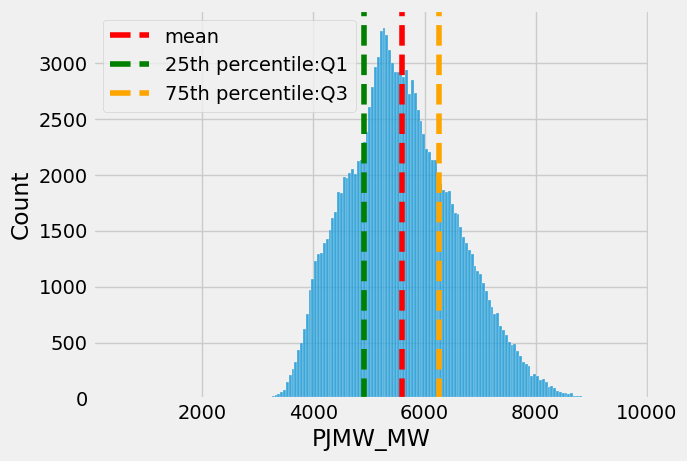

In [9]:
sns.histplot(df['PJMW_MW'])
plt.axvline(x=np.mean(df['PJMW_MW']), c='red', ls='--', label='mean')
plt.axvline(x=np.percentile(df['PJMW_MW'],25),c='green', ls='--', label = '25th percentile:Q1')
plt.axvline(x=np.percentile(df['PJMW_MW'],75),c='orange', ls='--',label = '75th percentile:Q3' )
plt.legend()

Though there is variation in the data i.e, there is peak point as well as low points, there is no any specific trend. It looks like a stationary series with constatnt mean and sd.

## Density Plot

<Axes: ylabel='Density'>

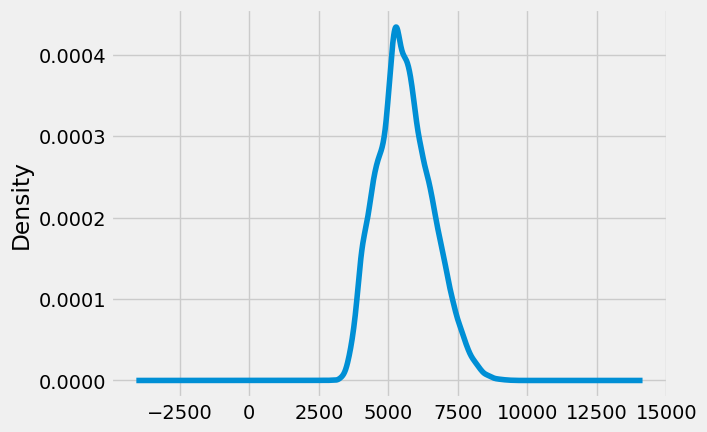

In [10]:
# Create a kernel density plot
df.PJMW_MW.plot(kind='kde')

## We are using first row of the data as the column headers and the first column as the DataFrame index

In [59]:
df = pd.read_excel("/content/PJMW_MW_Hourly.xlsx", header=0, index_col=0, parse_dates=True)
df.head()

PJMW_MW
Datetime                    
2002-12-31 01:00:00     5077
2002-12-31 02:00:00     4939
2002-12-31 03:00:00     4885
2002-12-31 04:00:00     4857
2002-12-31 05:00:00     4930

In [60]:
df.shape

(143206, 1)

## Lag Plot

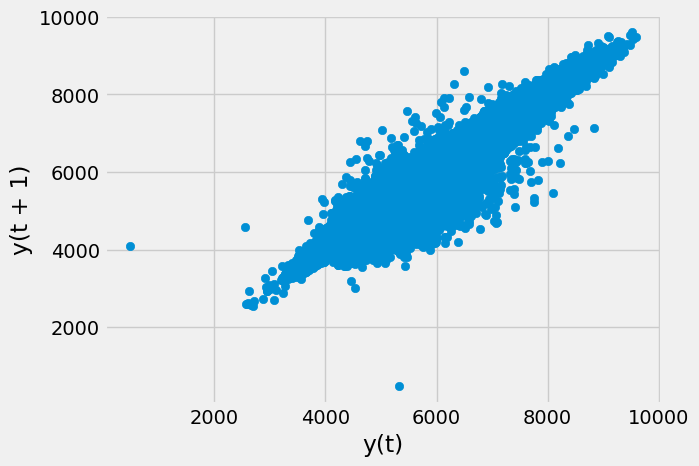

In [61]:
# Create a scatter plot 
from pandas.plotting import lag_plot

lag_plot(df)
plt.show()

In [62]:
df.describe()

PJMW_MW
count  143206.000000
mean     5602.375089
std       979.142872
min       487.000000
25%      4907.000000
50%      5530.000000
75%      6252.000000
max      9594.000000

## Outlier Analysis and Removal

In [ ]:
df.query('PJMW_MW <3500')['PJMW_MW'] \
    .plot(style= '.',
        figsize= (15,5),
        color= color_pal[5],
        title= 'Possibility of having Outliers')

In [ ]:
df.query('PJMW_MW <2889.5')['PJMW_MW'] \
    .plot(style= '.',
        figsize= (15,5),
        color= color_pal[5],
        title= 'Outliers which is present below lower_limit(PJMW_MW- 2889.5)')

In [ ]:
df.query('PJMW_MW >8269.5')['PJMW_MW'] \
    .plot(style= '.',
        figsize= (15,5),
        color= color_pal[5],
        title= 'Outliers which is present above upper_limit(PJMW_MW- 8269.5)')

In [63]:
Q1= df.PJMW_MW.quantile(0.25)
Q3= df.PJMW_MW.quantile(0.75)
Q1, Q3

(4907.0, 6252.0)

In [64]:
IQR= Q3- Q1
IQR

1345.0

In [65]:
lower_limit= Q1 - 1.5*IQR
upper_limit= Q3 + 1.5*IQR
lower_limit, upper_limit

(2889.5, 8269.5)

In [66]:
df[(df.PJMW_MW< lower_limit)|(df.PJMW_MW> upper_limit)]
df.head()

PJMW_MW
Datetime                    
2002-12-31 01:00:00     5077
2002-12-31 02:00:00     4939
2002-12-31 03:00:00     4885
2002-12-31 04:00:00     4857
2002-12-31 05:00:00     4930

In [67]:
df= df[(df.PJMW_MW> lower_limit)&(df.PJMW_MW< upper_limit)]
df.tail()

PJMW_MW
Datetime                    
2018-01-01 17:00:00     7747
2018-01-01 18:00:00     8213
2018-01-01 22:00:00     8238
2018-01-01 23:00:00     7958
2018-01-02 00:00:00     7691

In [68]:
df.shape

(142503, 1)

In [69]:
df.dtypes

PJMW_MW    int64
dtype: object

In [70]:
df.describe()

PJMW_MW
count  142503.000000
mean     5588.247384
std       959.088761
min      2922.000000
25%      4902.000000
50%      5524.000000
75%      6239.000000
max      8269.000000

We have the hourly energy consumption data with 142503 rows from 2002 to 2018, after removing the outliers. 

In [71]:
df = df.sort_index()

Sorted the dataset to arrange it in ascending order

After sorting we found out that the data is from April 2002 to August 2018

<Axes: xlabel='Datetime'>

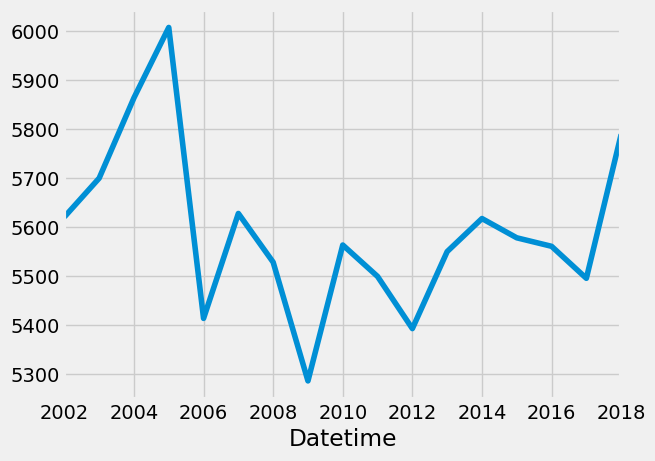

In [72]:
df.PJMW_MW.resample(rule='A').mean().plot()

<Axes: xlabel='Datetime'>

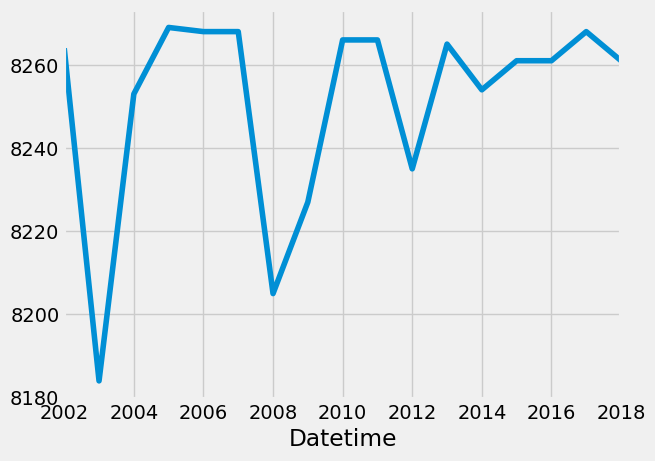

In [73]:
df.PJMW_MW.resample(rule='A').max().plot()

<Axes: xlabel='Datetime'>

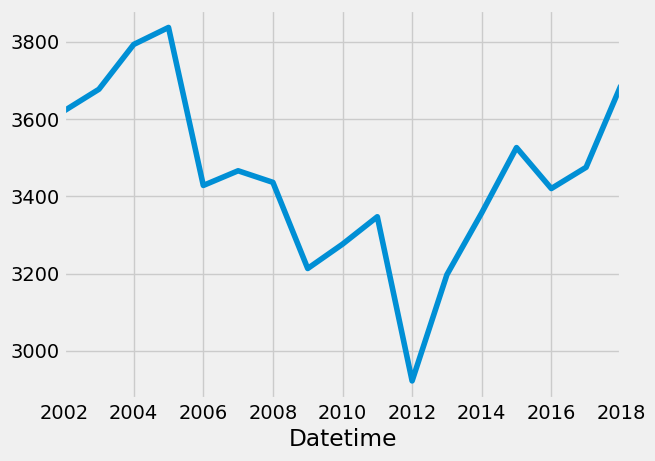

In [74]:
df.PJMW_MW.resample(rule='A').min().plot()

In [75]:
df.to_csv('dataset.csv')

In [76]:
type(df)

pandas.core.frame.DataFrame

In [77]:
df1=df.copy()

In [78]:
df1.head()

PJMW_MW
Datetime                    
2002-04-01 01:00:00     4374
2002-04-01 02:00:00     4306
2002-04-01 03:00:00     4322
2002-04-01 04:00:00     4359
2002-04-01 05:00:00     4436

#### Extract the date, month, year, hour and weekname columns for further visualization

In [113]:
df1["Date"] = pd.to_datetime(df1.index,format='%Y-%m-%d %H:%M')

# Extracting Day, month name, year from the Datetime column using Date functions from pandas 

df1["month"] = df1.Date.dt.strftime("%b") # month extraction
df1["year"] = df1.Date.dt.strftime("%Y") # year extraction
df1["day"] = df1.Date.dt.strftime("%d") # day extraction
df1["Hour"] = df1.Date.dt.strftime("%H") # Hour extraction
df1['quarter'] = df1.index.quarter

In [115]:
df1 = df1.sort_index()

In [116]:
df1.drop('Date',axis=1,inplace=True)

In [117]:
# df1 = df1.reset_index()

# df1['weekday'] = df1['Datetime'].dt.dayofweek

# df1['weekday'] = pd.to_datetime(df1.index).day_of_week
df1['weekday_name'] = pd.to_datetime(df1.index).day_name()


In [118]:
df1.head()

PJMW_MW month  year day Hour weekday_name  quarter
Datetime                                                               
2002-04-01 01:00:00     4374   Apr  2002  01   01       Monday        2
2002-04-01 02:00:00     4306   Apr  2002  01   02       Monday        2
2002-04-01 03:00:00     4322   Apr  2002  01   03       Monday        2
2002-04-01 04:00:00     4359   Apr  2002  01   04       Monday        2
2002-04-01 05:00:00     4436   Apr  2002  01   05       Monday        2

## Heatmap

<Axes: xlabel='month', ylabel='year'>

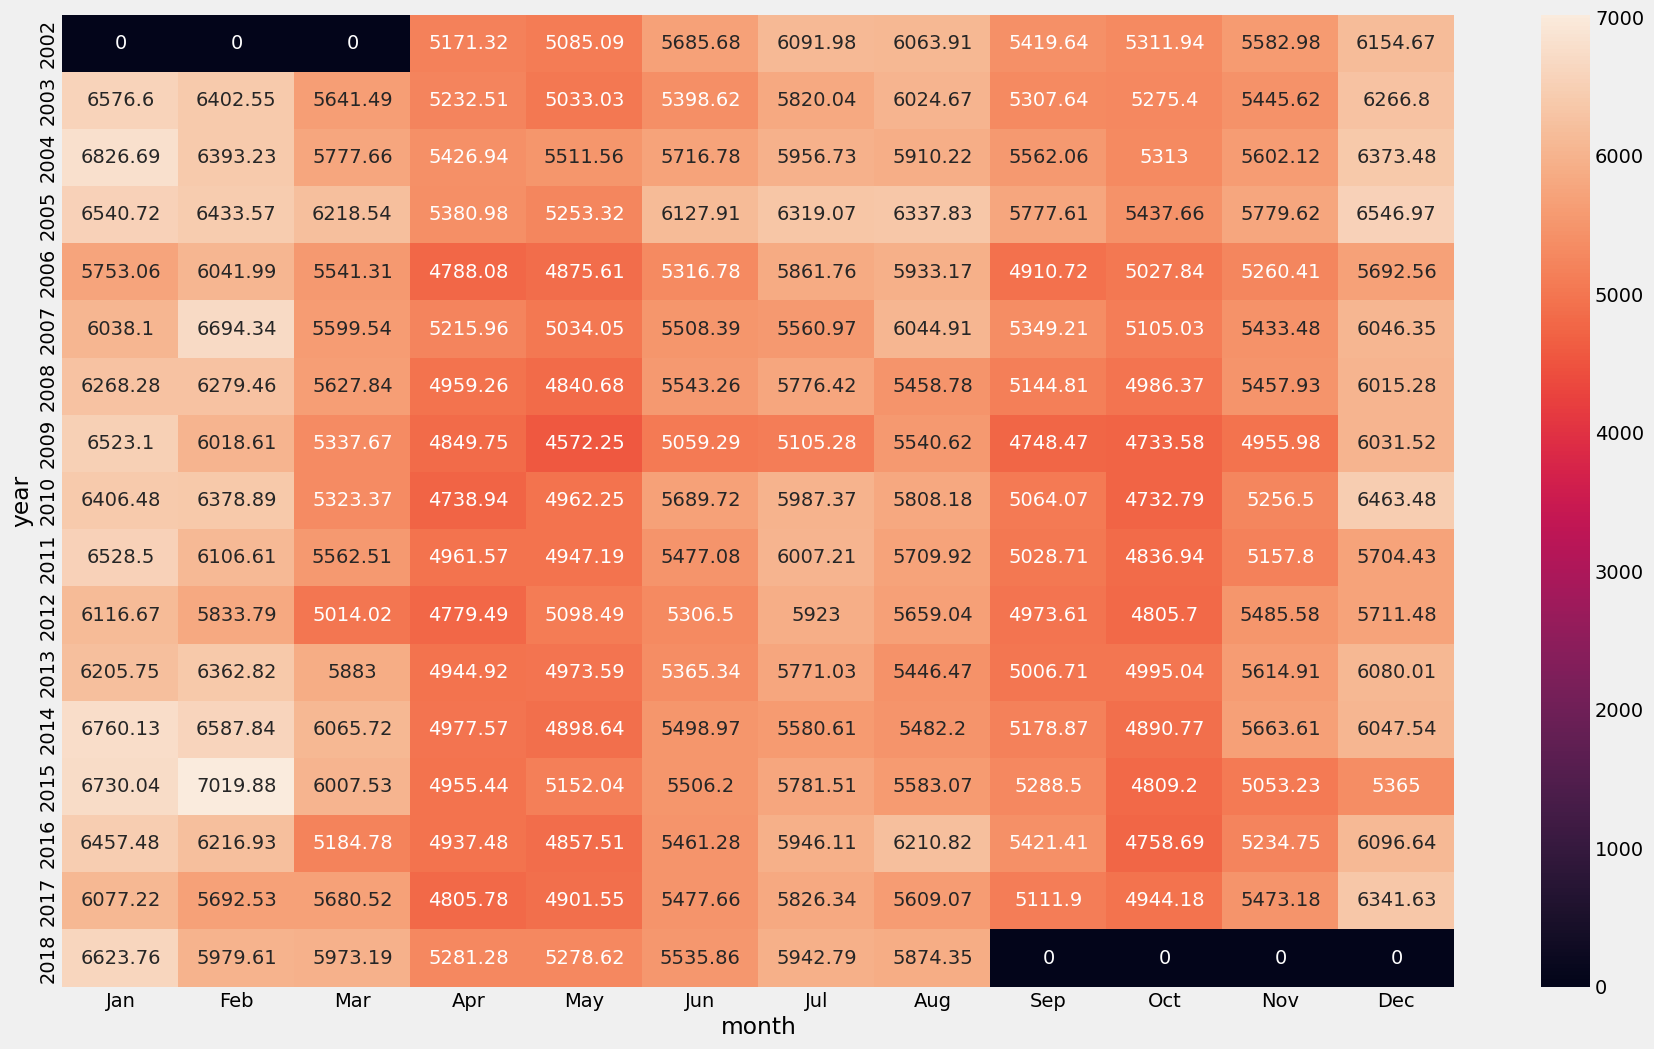

In [84]:
# Define the custom order of months
month_order = ['Jan','Feb','Mar','Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Create a pivot table with the custom order of months
heatmap_y_month = pd.pivot_table(data=df1, values='PJMW_MW', index='year', columns='month', aggfunc='mean', fill_value=0)
heatmap_y_month = heatmap_y_month.reindex(month_order, axis=1)
plt.figure(figsize= (20,12))
sns.heatmap(heatmap_y_month, annot= True, fmt= 'g') # fmt is format of the grid values

<Axes: xlabel='year', ylabel='PJMW_MW'>

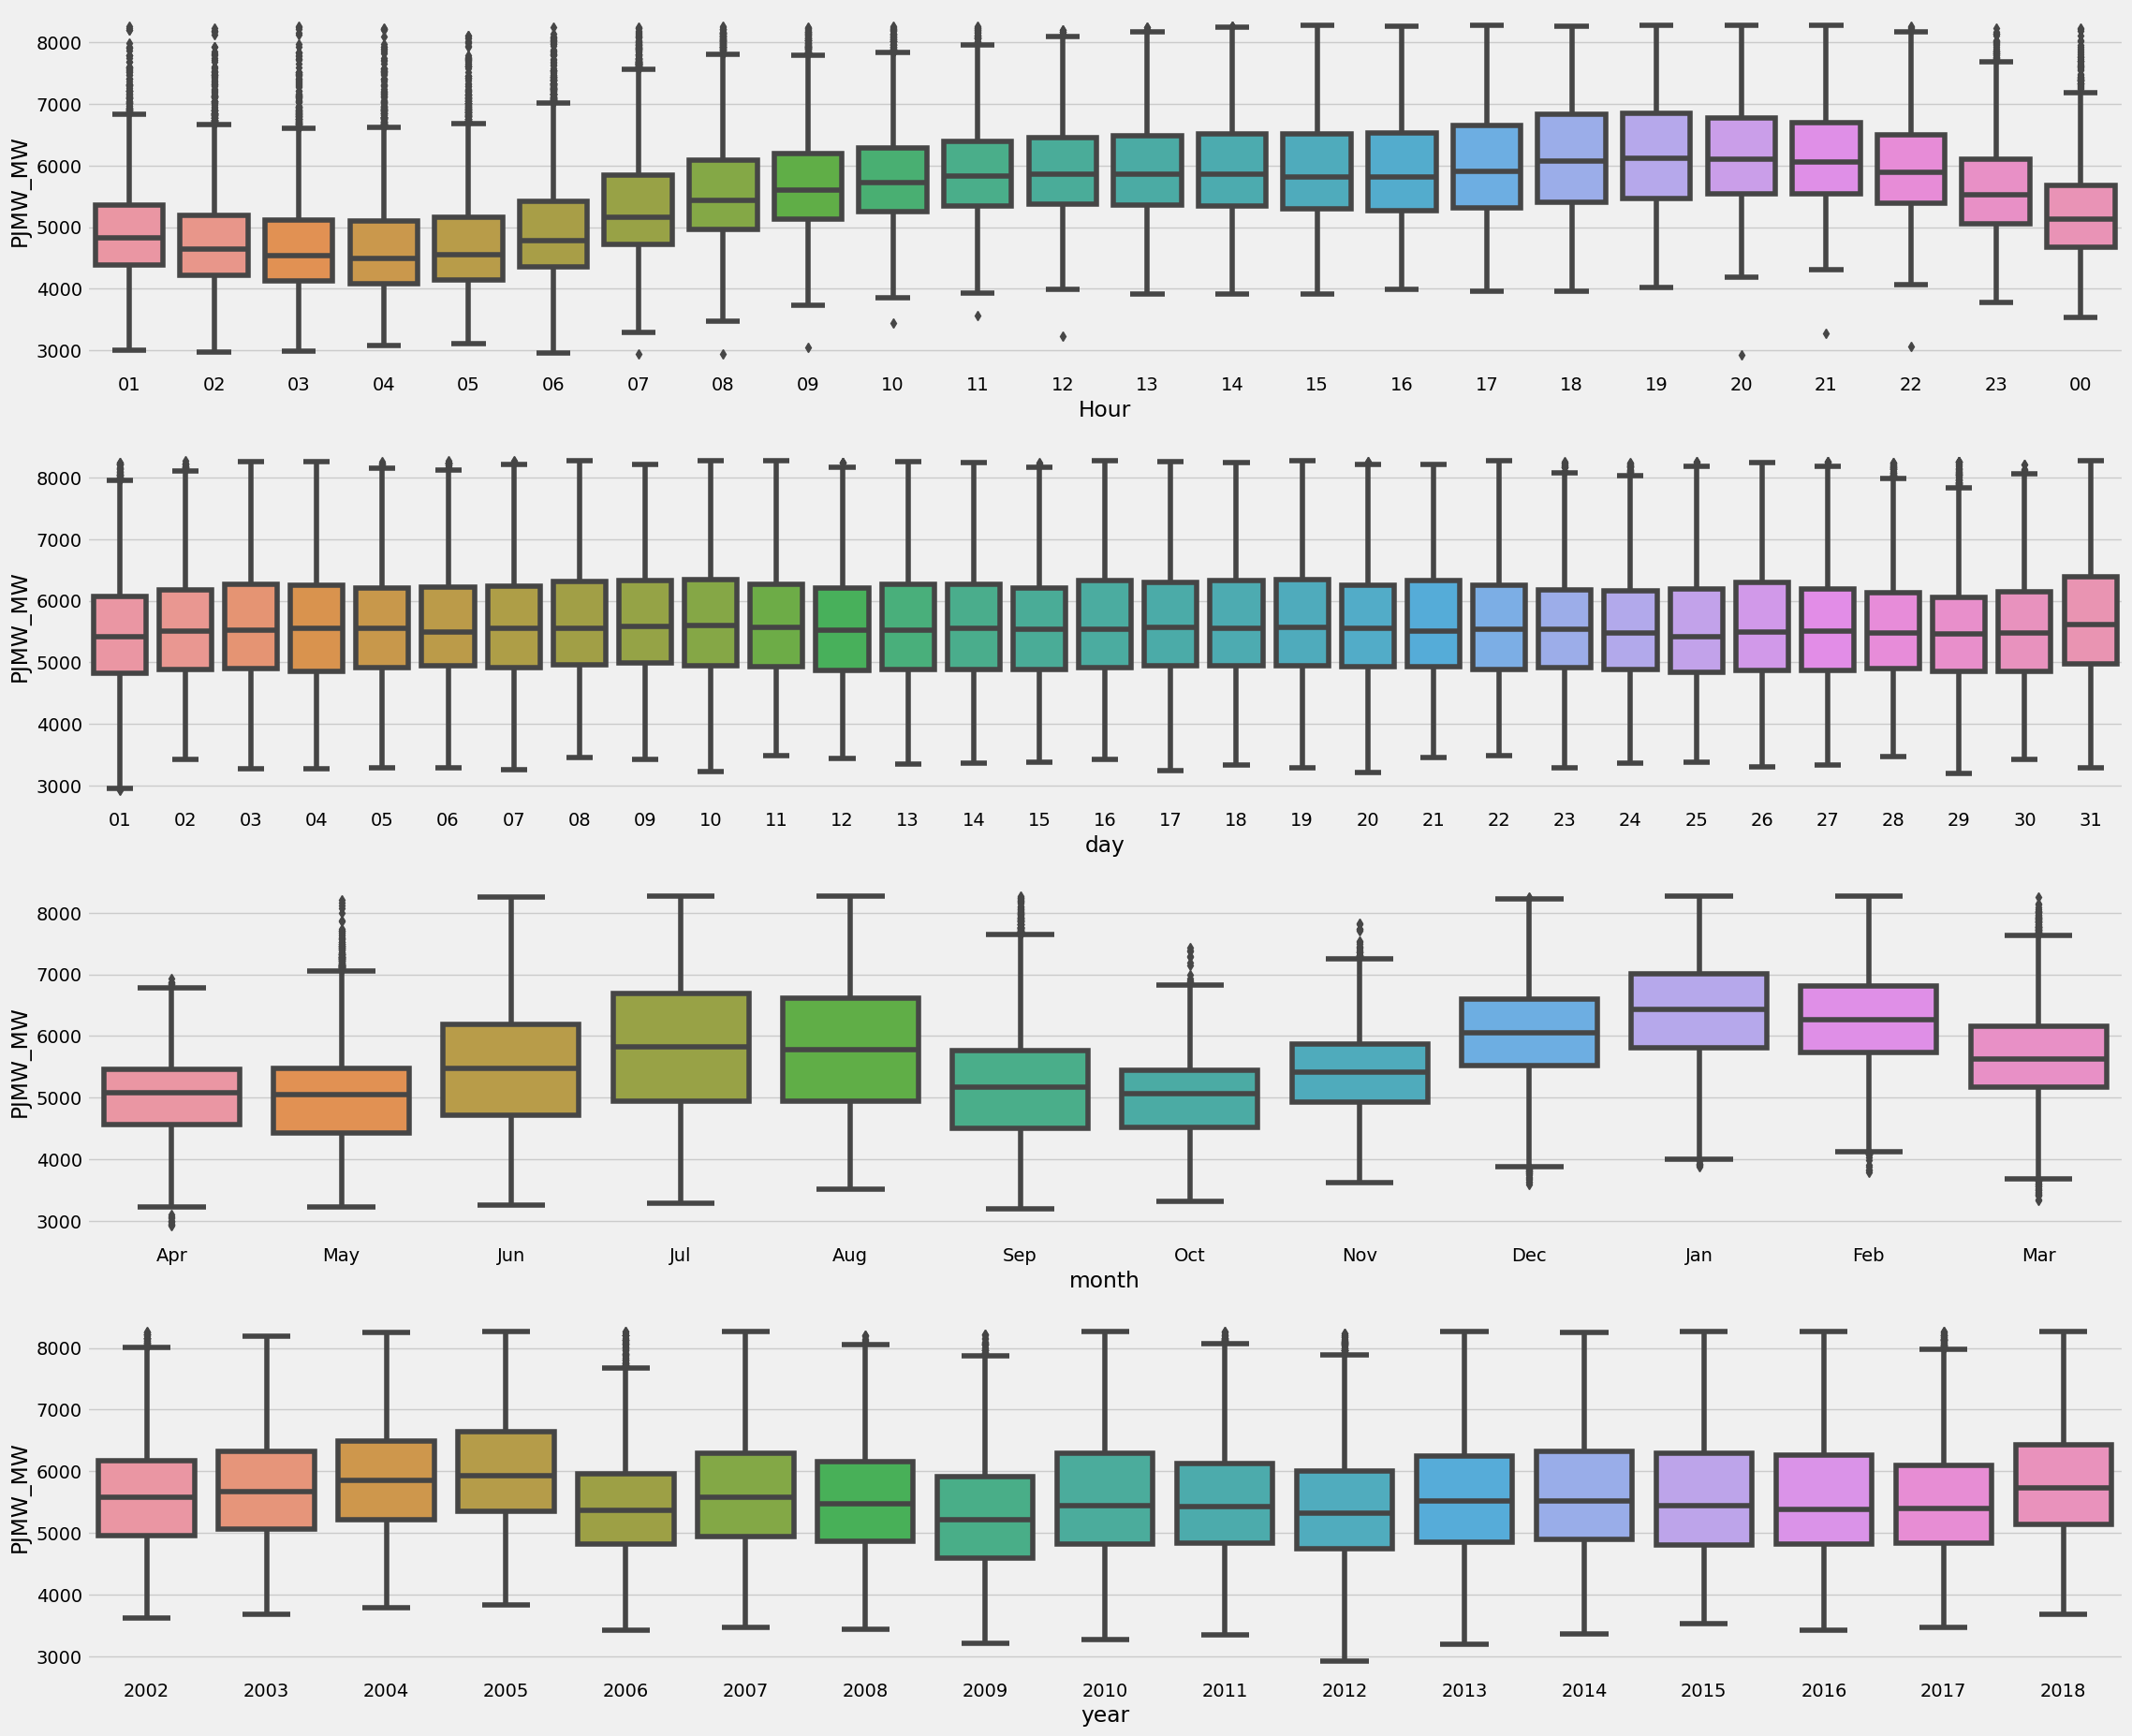

In [85]:
# Boxplot
plt.figure(figsize= (25,22))

plt.subplot(411)
sns.boxplot(x= 'Hour', y='PJMW_MW', data= df1)
plt.subplot(412)
sns.boxplot(x='day', y= 'PJMW_MW', data= df1)
plt.subplot(413)
sns.boxplot(x= 'month', y='PJMW_MW', data= df1)
plt.subplot(414)
sns.boxplot(x='year', y= 'PJMW_MW', data= df1)

In [86]:
df1.head()

PJMW_MW month  year day Hour weekday_name
Datetime                                                      
2002-04-01 01:00:00     4374   Apr  2002  01   01       Monday
2002-04-01 02:00:00     4306   Apr  2002  01   02       Monday
2002-04-01 03:00:00     4322   Apr  2002  01   03       Monday
2002-04-01 04:00:00     4359   Apr  2002  01   04       Monday
2002-04-01 05:00:00     4436   Apr  2002  01   05       Monday

## Pie Plot

Text(0.5, 1.0, 'hour')

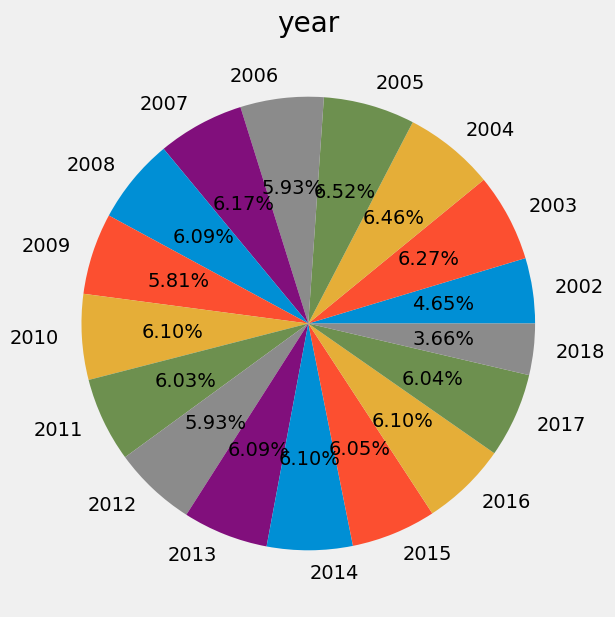

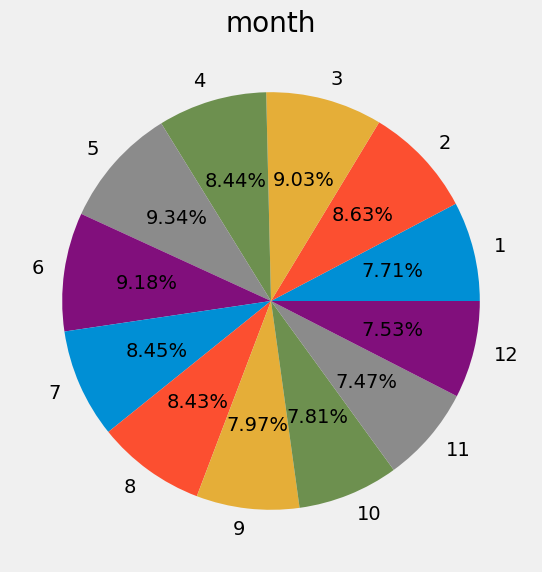

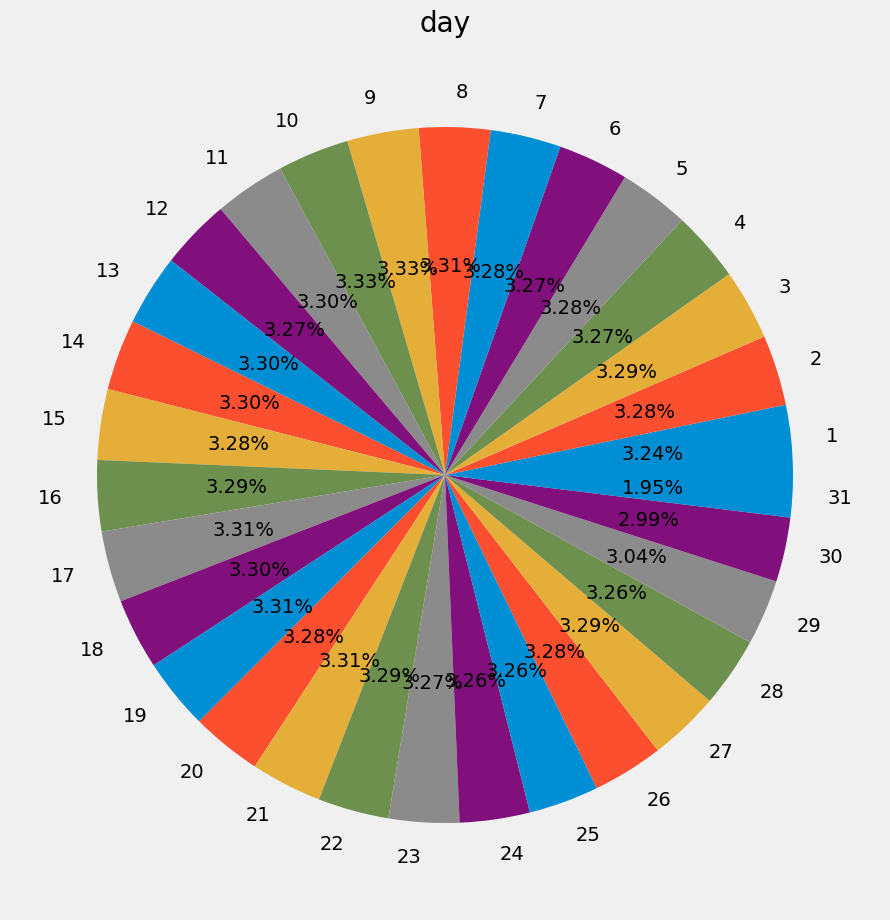

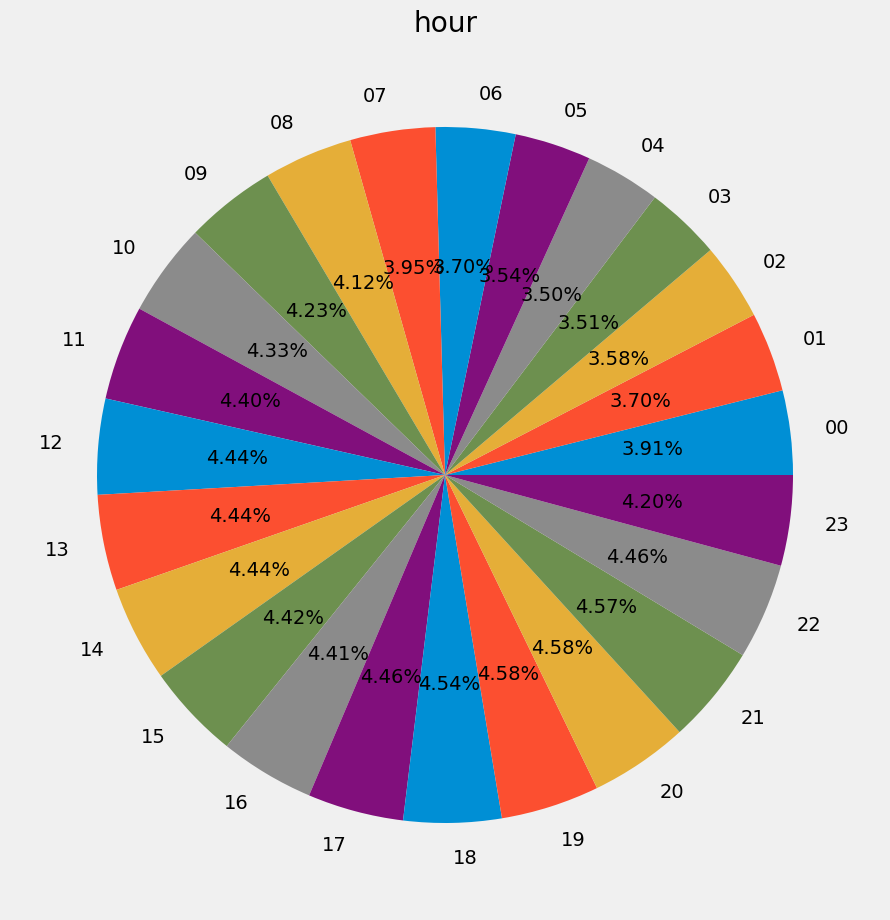

In [87]:
#pie plot
b=df1.groupby('year')[['PJMW_MW']].sum()
b=np.array(b['PJMW_MW'])
l=['2002','2003','2004','2005','2006','2007','2008','2009','2010','2011','2012','2013','2014','2015','2016','2017','2018']
plt.figure(figsize=(10,7))
plt.pie(b,labels=l,autopct='%1.2f%%')
plt.title('year')

c=df1.groupby('month')[['PJMW_MW']].sum()
c=np.array(c['PJMW_MW'])
l=['1','2','3','4','5','6','7','8','9','10','11','12']
plt.figure(figsize=(6,7))
plt.pie(c,labels=l,autopct='%1.2f%%')
plt.title('month')

d=df1.groupby('day')[['PJMW_MW']].sum()
d=np.array(d['PJMW_MW'])
l=['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','23','24','25','26','27','28','29','30','31']
plt.figure(figsize=(10,15))
plt.pie(d,labels=l,autopct='%1.2f%%')
plt.title('day')

e=df1.groupby('Hour')[['PJMW_MW']].sum()
e=np.array(e['PJMW_MW'])
l=['00','01','02','03','04','05','06','07','08','09','10','11','12','13','14','15','16','17','18','19','20','21','22','23']
plt.figure(figsize=(10,15))
plt.pie(e,labels=l,autopct='%1.2f%%')
plt.title('hour')

## Line Plot

In [105]:
df1.head()

PJMW_MW month  year day Hour weekday_name  quarter
Datetime                                                               
2002-04-01 01:00:00     4374   Apr  2002  01   01       Monday        2
2002-04-01 02:00:00     4306   Apr  2002  01   02       Monday        2
2002-04-01 03:00:00     4322   Apr  2002  01   03       Monday        2
2002-04-01 04:00:00     4359   Apr  2002  01   04       Monday        2
2002-04-01 05:00:00     4436   Apr  2002  01   05       Monday        2

In [120]:
# Creating times grouped dataframes in order to analyse them
df1_year = df1.groupby('year')['PJMW_MW'].sum()
df1_month = df1.groupby('month', sort = False)['PJMW_MW'].sum()
df1_quarter = df1.groupby('quarter')['PJMW_MW'].sum()
df1_weekday_name = df1.groupby('weekday_name', sort = False)['PJMW_MW'].sum()
df1_day = df1.groupby('day')['PJMW_MW'].sum()
df1_Hour = df1.groupby('Hour')['PJMW_MW'].sum()

In [127]:
# Creating a plotly subplot
fig = make_subplots(rows=3, cols=2, vertical_spacing = 0.175,
                    subplot_titles=(['Year', 'Month', 'Day of Month','Hour', 'Quarter']))

fig.add_trace(go.Scatter(x=df1_year.index, y = df1_year), row=1, col=1)
fig.add_trace(go.Scatter(x=df1_month.index, y=df1_month), row=1, col=2)
fig.add_trace(go.Scatter(x=df1_day.index, y=df1_day), row=2, col=2)
fig.add_trace(go.Scatter(x=df1_Hour.index, y=df1_Hour), row=2, col=1)
fig.add_trace(go.Scatter(x=df1_quarter.index, y=df1_quarter), row=3, col=1)

fig.update_layout(title = 'Energy Consumption of PJMW per', height = 700, showlegend = False)

fig.show()

<Axes: xlabel='quarter', ylabel='PJMW_MW'>

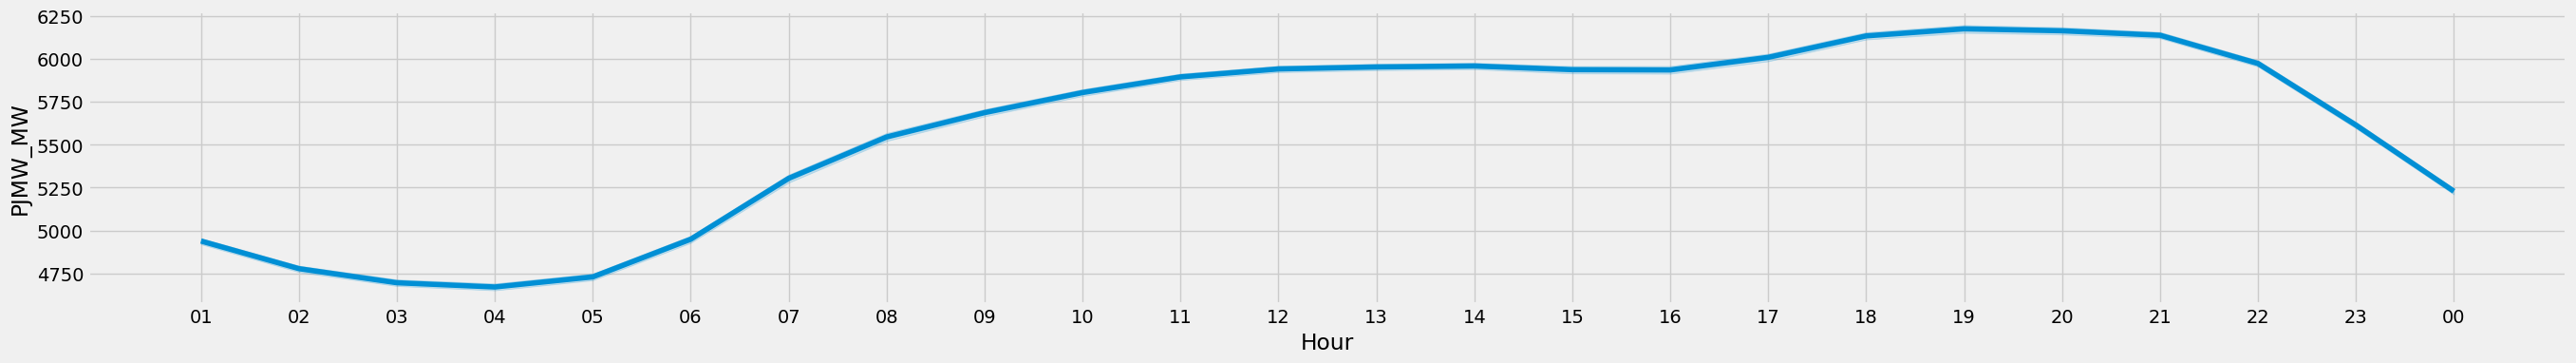

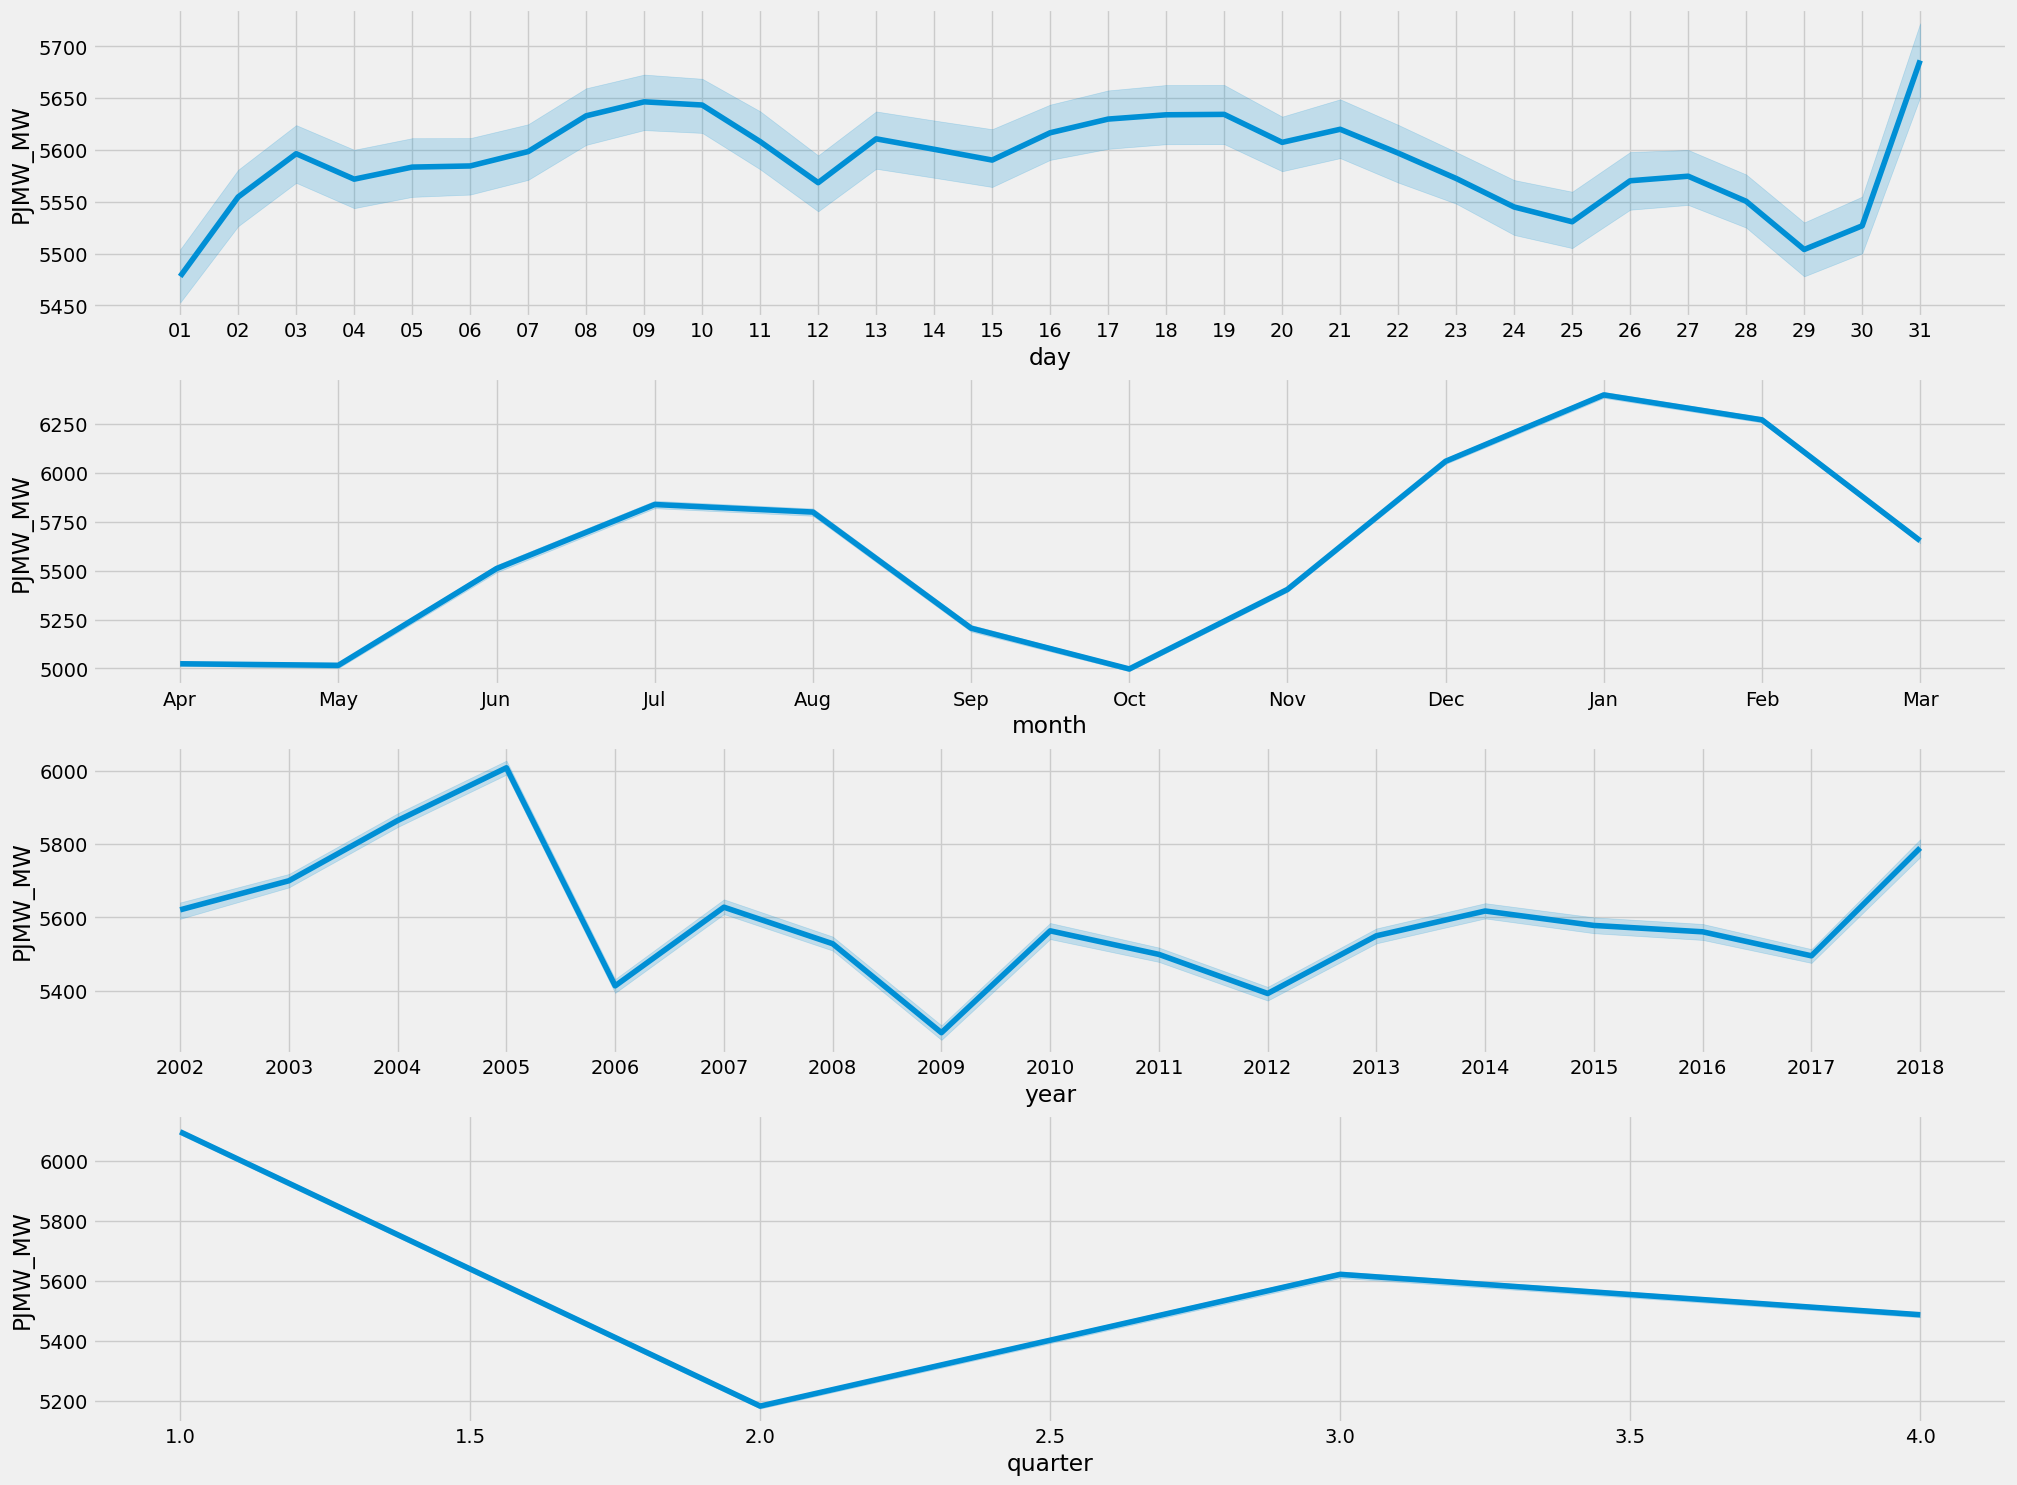

In [131]:
plt.figure(figsize= (30,22))
plt.subplot(511)
sns.lineplot(x='Hour', y= 'PJMW_MW', data= df1)

plt.figure(figsize= (22,22))
plt.subplot(512)
sns.lineplot(x='day', y= 'PJMW_MW', data= df1)

plt.subplot(513)
sns.lineplot(x='month', y= 'PJMW_MW', data= df1)

plt.subplot(514)
sns.lineplot(x='year', y= 'PJMW_MW', data= df1)

plt.subplot(515)
sns.lineplot(x='quarter', y= 'PJMW_MW', data= df1)

## ACF and PACF Plot

/usr/local/lib/python3.9/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



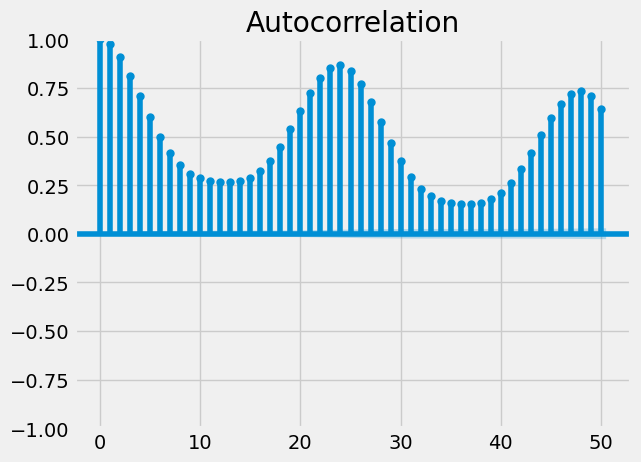

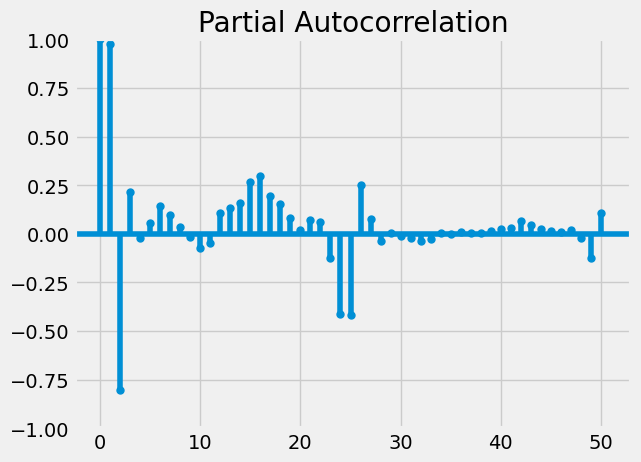

In [132]:
# Create an autocorrelation plot 
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.graphics.tsaplots as tsa_plots
tsa_plots.plot_acf(df1.PJMW_MW, lags= 50)
tsa_plots.plot_pacf(df1.PJMW_MW,lags= 50)
plt.show();

## Cat Plot

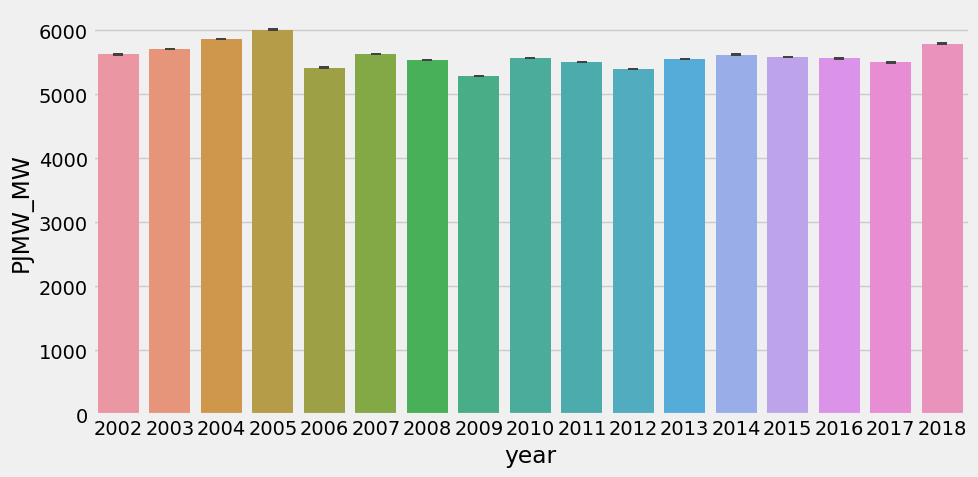

In [92]:
sns.catplot(x='year',y='PJMW_MW',data=df1,kind='bar',aspect=2)

Observation: Low consumption in 2009 and high consumption in 2005

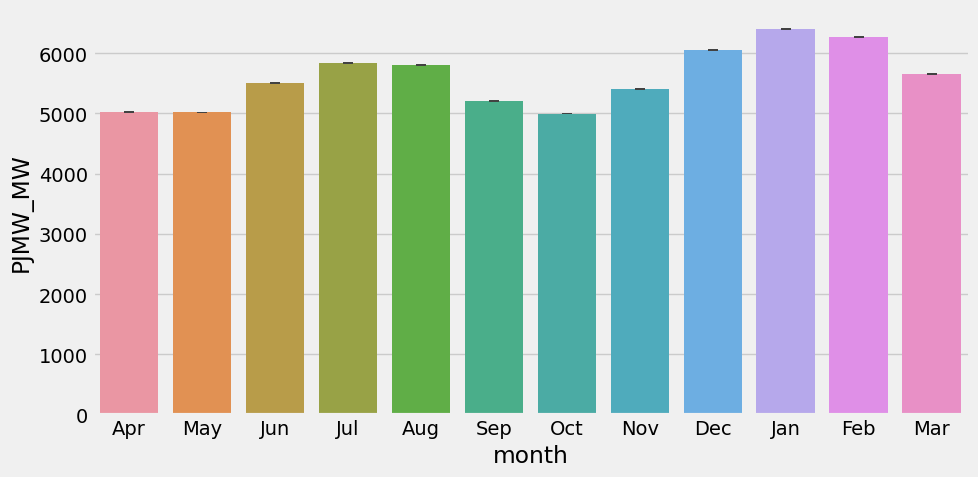

In [93]:
sns.catplot(x='month',y='PJMW_MW',data=df1,kind='bar',aspect=2)

Observation: For Dec, Jan, Feb and Jun,Jul, Aug the consumptin is higher as compared to other months.

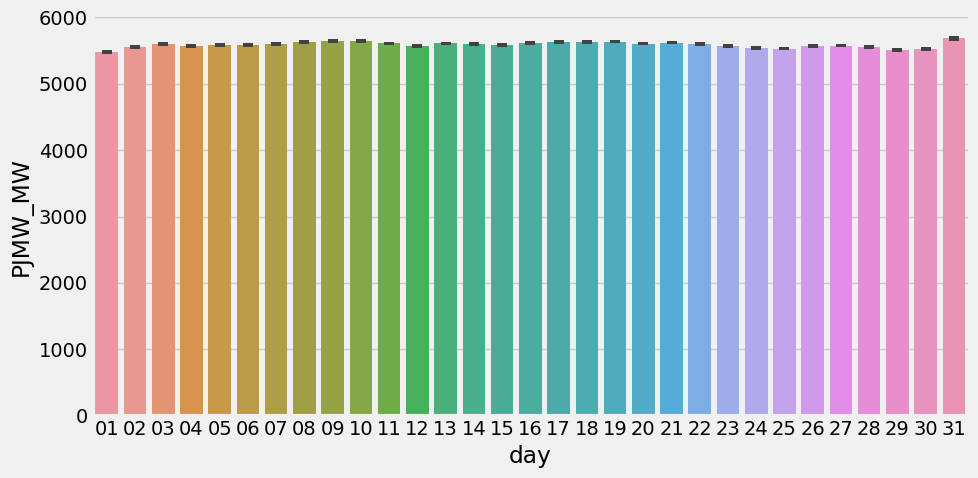

In [94]:
sns.catplot(x='day',y='PJMW_MW',data=df1,kind='bar',aspect=2)

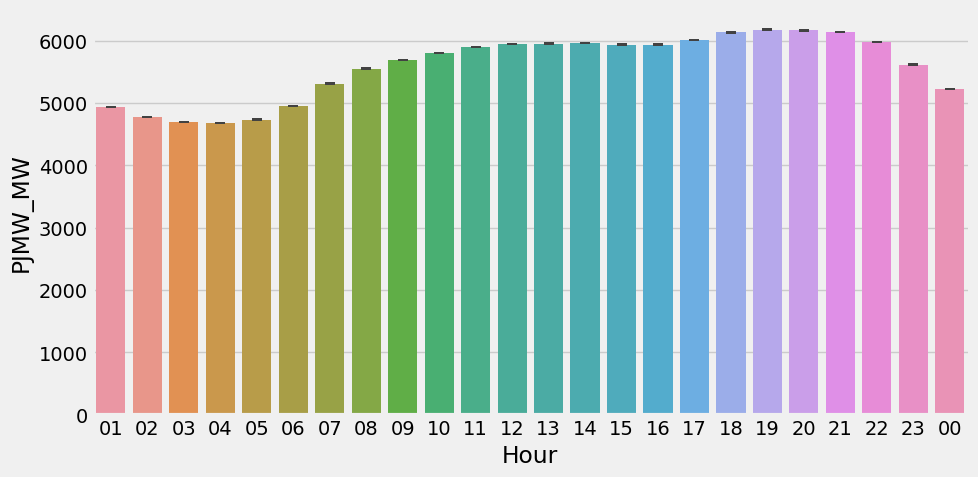

In [95]:
sns.catplot(x='Hour',y='PJMW_MW',data=df1,kind='bar',aspect=2)

Observation: From midnight after 10 pm the power consumption starts decreasing and from morning 7 it increases till 10 pm.

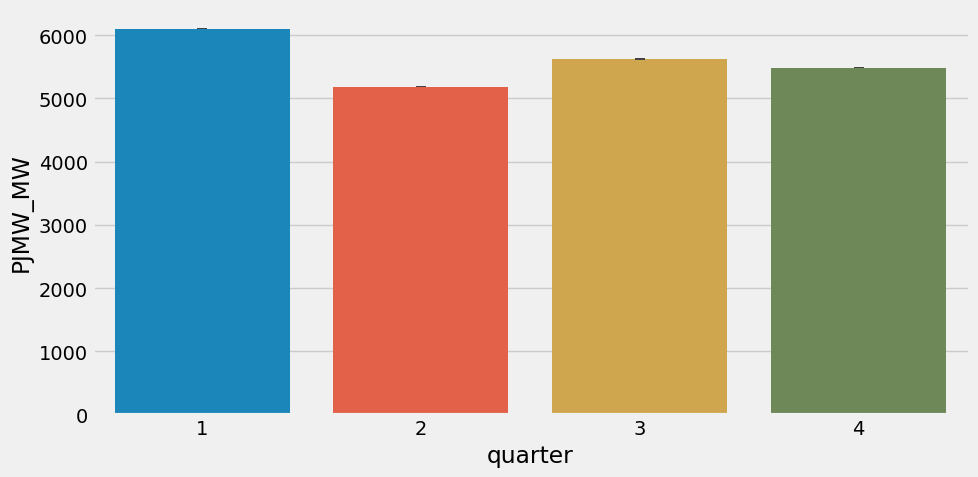

In [133]:
sns.catplot(x='quarter',y='PJMW_MW',data=df1,kind='bar',aspect=2)

Observation: 1st quarter has the highest power consumption and 2nd quarter has the lowest power consumption

## Violin Plot

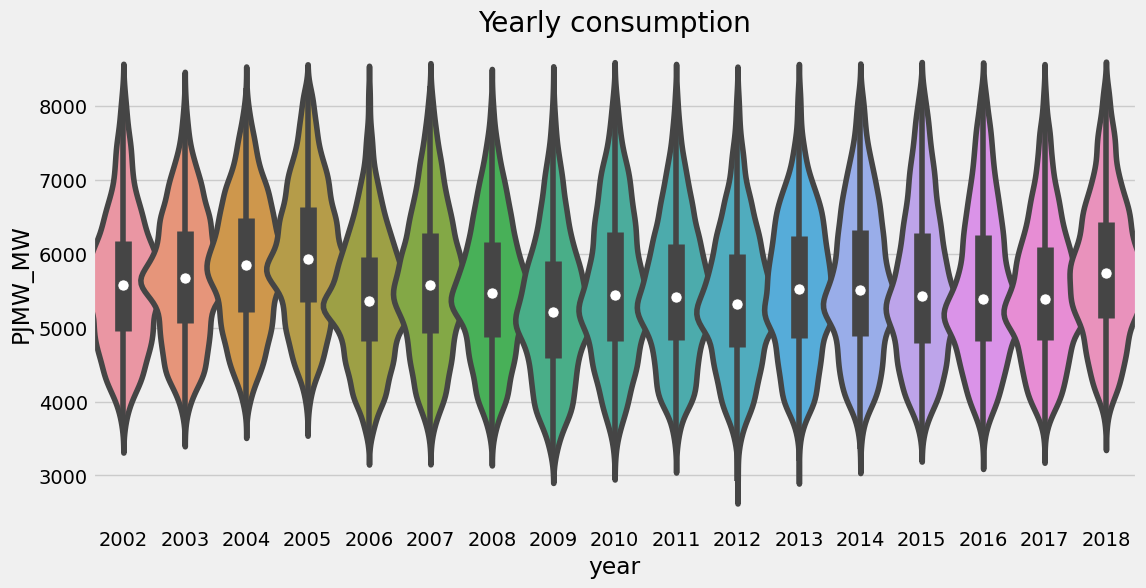

In [96]:
# set the size of the figure
plt.figure(figsize=(12, 6))

# create the violin plot
plot1 = sns.violinplot(x='year', y='PJMW_MW', data=df1, width=1.5, gridsize=100)
plot1.set(title='Yearly consumption')

# display the plot
plt.show()

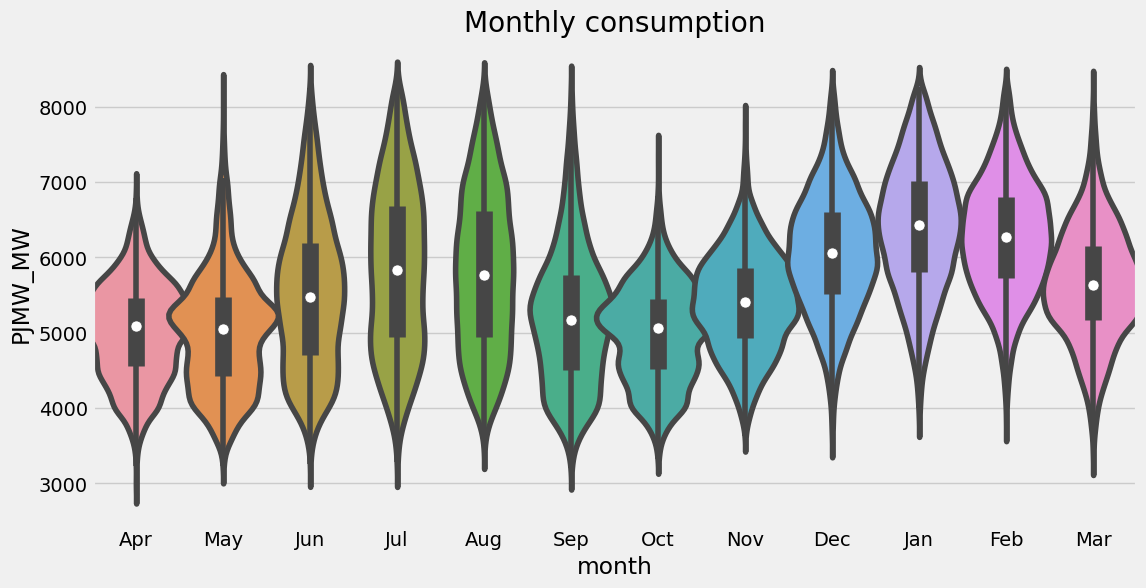

In [97]:
# set the size of the figure
plt.figure(figsize=(12, 6))

# create the violin plot
plot1 = sns.violinplot(x='month', y='PJMW_MW', data=df1, width=1.5, gridsize=100)
plot1.set(title='Monthly consumption')

# display the plot
plt.show()

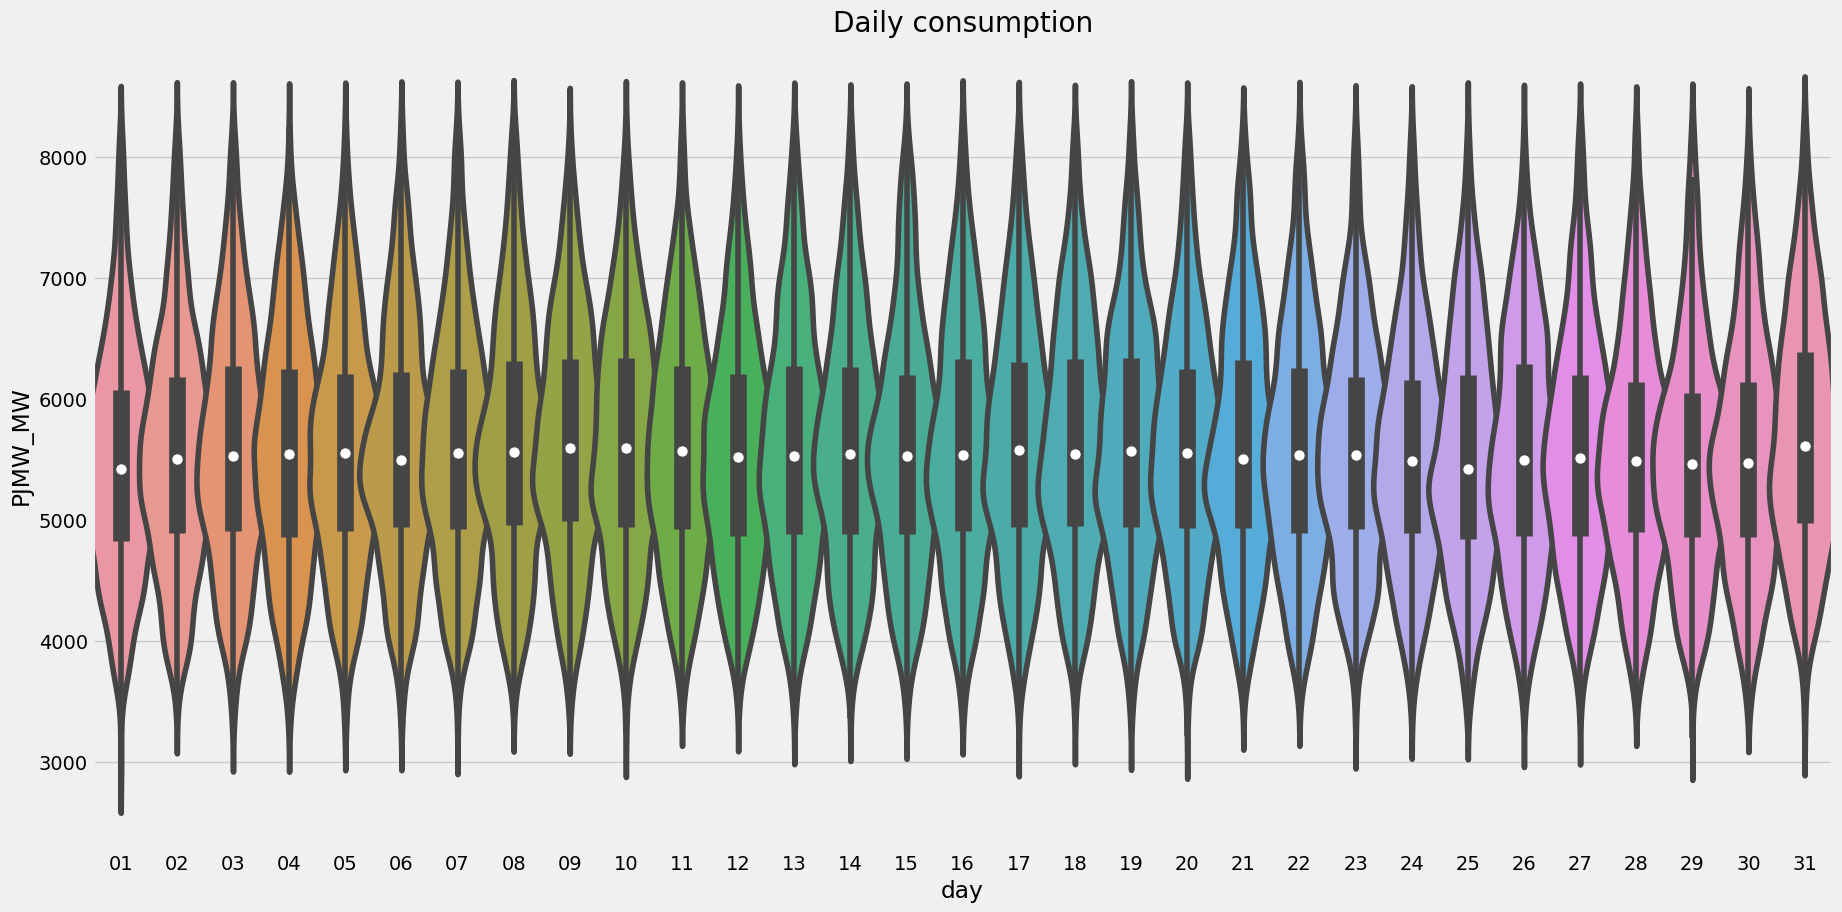

In [98]:
# set the size of the figure
plt.figure(figsize=(20, 10))

# create the violin plot
plot1 = sns.violinplot(x='day', y='PJMW_MW', data=df1, width=1.5, gridsize=100)
plot1.set(title='Daily consumption')

# display the plot
plt.show()

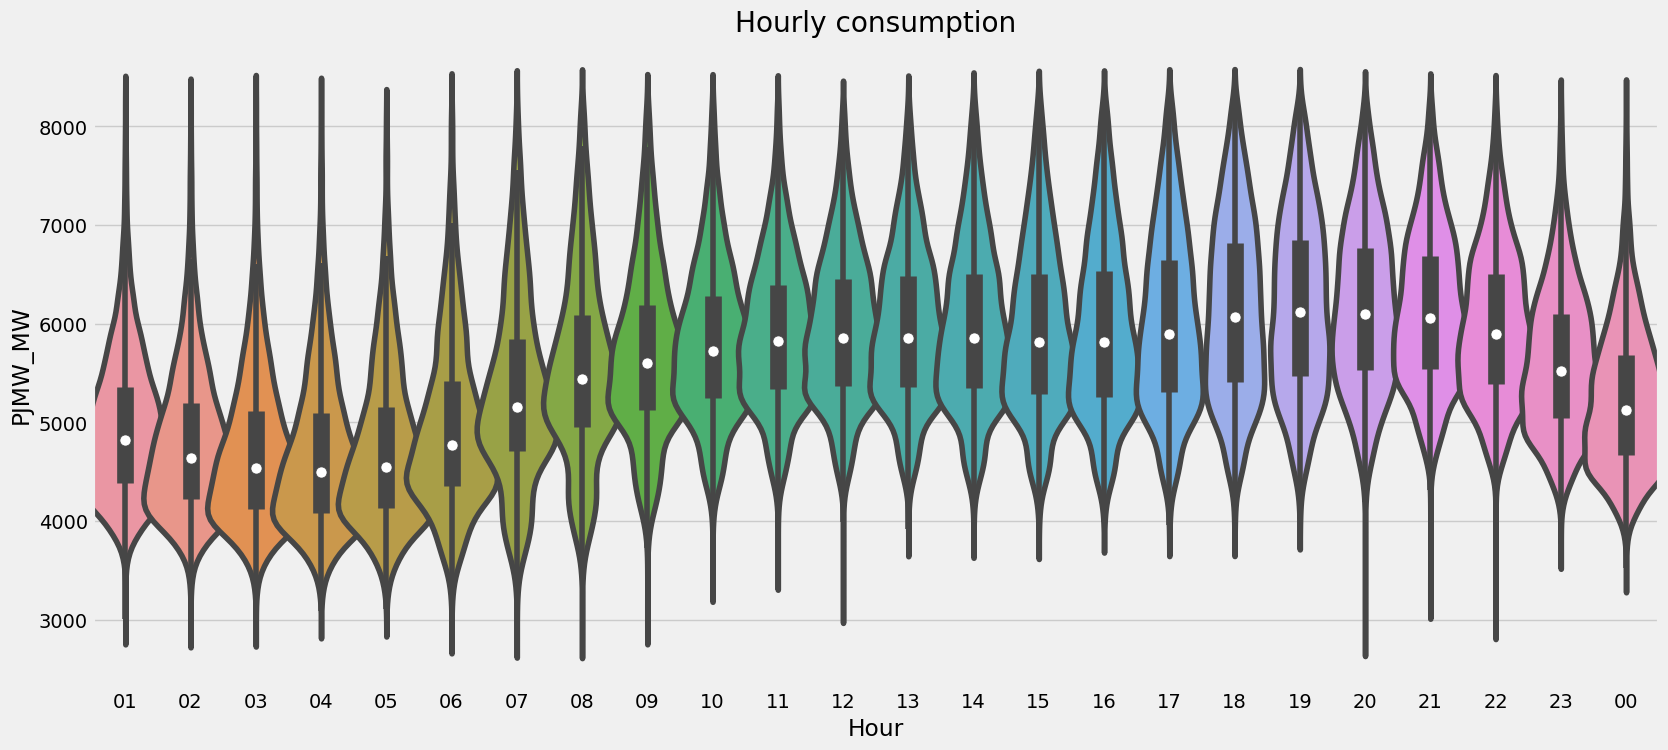

In [99]:
# set the size of the figure
plt.figure(figsize=(18, 8))

# create the violin plot
plot1 = sns.violinplot(x='Hour', y='PJMW_MW', data=df1, width=1.5, gridsize=100)
plot1.set(title='Hourly consumption')

# display the plot
plt.show()

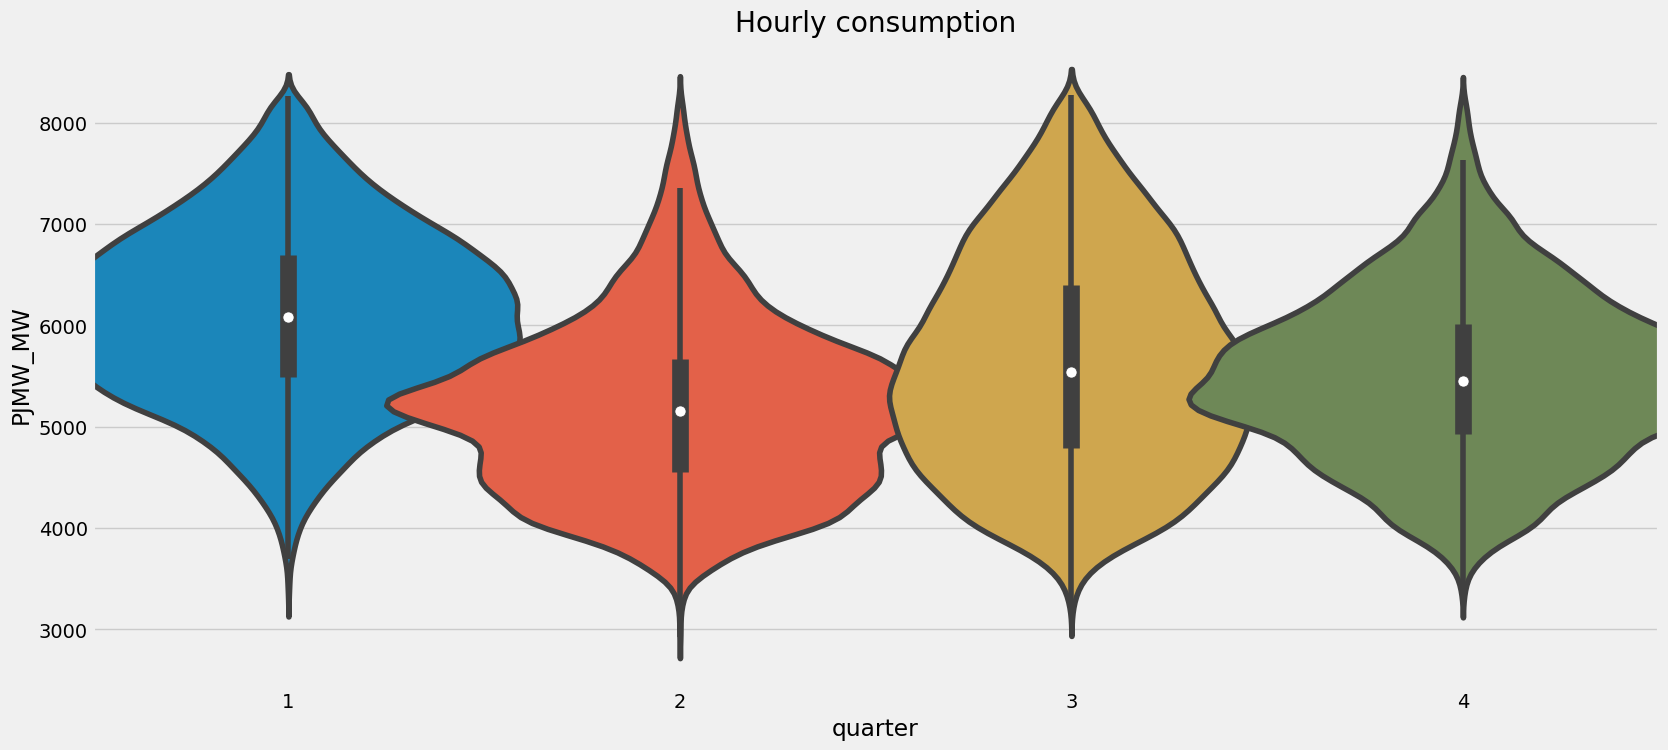

In [134]:
# set the size of the figure
plt.figure(figsize=(18, 8))

# create the violin plot
plot1 = sns.violinplot(x='quarter', y='PJMW_MW', data=df1, width=1.5, gridsize=100)
plot1.set(title='Hourly consumption')

# display the plot
plt.show()

## Time Series Decomposition Plot

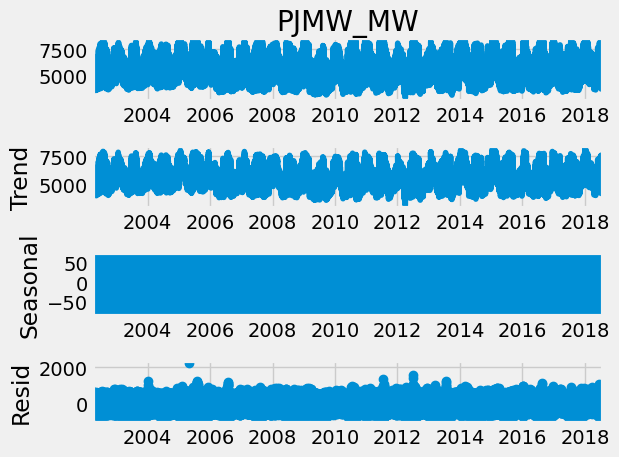

In [91]:
from statsmodels.tsa.seasonal import seasonal_decompose
decompose_ts_add = seasonal_decompose(df1.PJMW_MW,period=12)
decompose_ts_add.plot()
plt.show()

## Seasonal Plot

<ipython-input-135-c40f863a6e65>:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



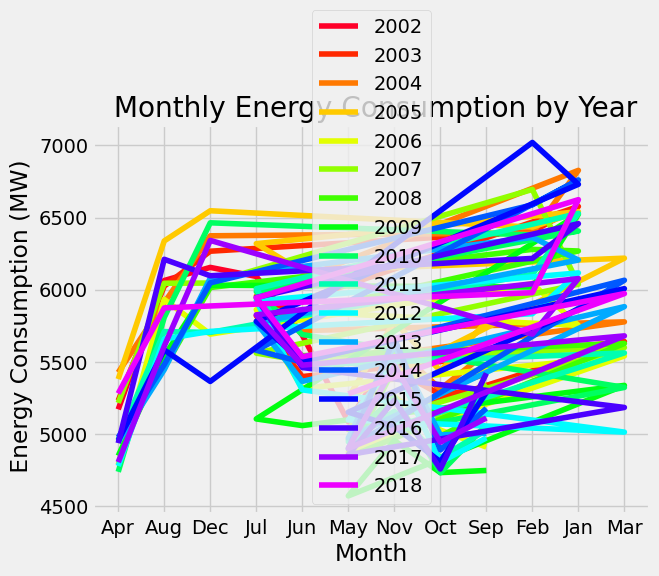

In [135]:
year_group = df1.groupby(['year', 'month']).mean().reset_index()
years = df1['year'].unique()
NUM_COLORS = len(years)

cm = plt.get_cmap('gist_rainbow')
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])

for i, y in enumerate(years):
    df = year_group[year_group['year'] == y]
    #rolling_mean = df.PJMW_MW.rolling(window=7*24).mean()
    plt.plot(df['month'], df['PJMW_MW'])
plt.title(' Monthly Energy Consumption by Year')
plt.xlabel('Month')
plt.ylabel(' Energy Consumption (MW)')
plt.legend(df1.year.unique())
plt.show()

## Moving Average

<ipython-input-136-1c1369246dbb>:5: FutureWarning:

Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['month', 'weekday_name'], dtype='object')

<ipython-input-136-1c1369246dbb>:6: FutureWarning:

Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['month', 'weekday_name'], dtype='object')

<ipython-input-136-1c1369246dbb>:7: FutureWarning:

Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['month', 'weekday_name'], dtype='object')



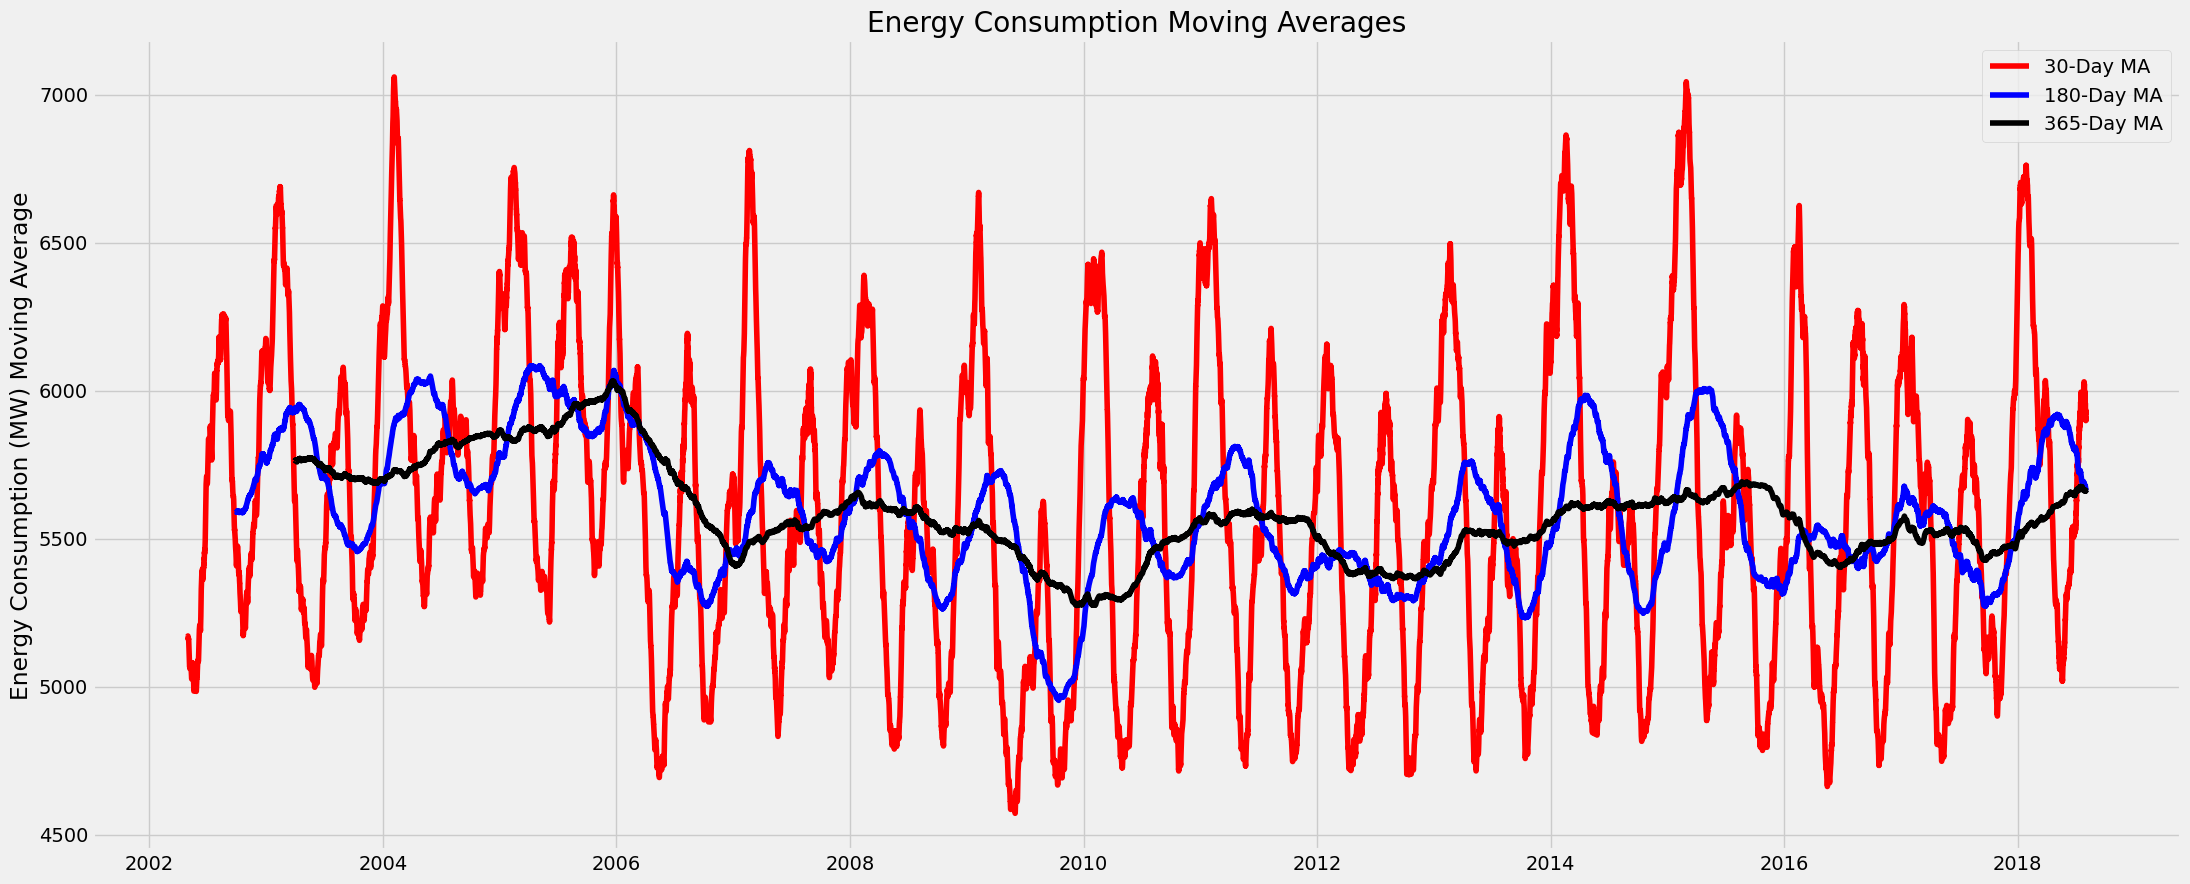

In [136]:
MONTH_PERIOD = 24*30
MIDYEAR_PERIOD = 24*182
YEAR_PERIOD = 24*365

month_roll = df1.rolling(MONTH_PERIOD).mean()
midyear_roll = df1.rolling(MIDYEAR_PERIOD).mean()
year_roll = df1.rolling(YEAR_PERIOD).mean()

fig, ax = plt.subplots(figsize=(24, 10))
plt.plot(month_roll.index, month_roll['PJMW_MW'], color='red', label='30-Day MA')
plt.plot(midyear_roll.index, midyear_roll['PJMW_MW'], color='blue', label='180-Day MA')
plt.plot(year_roll.index, year_roll['PJMW_MW'], color='black', label='365-Day MA')
plt.title('Energy Consumption Moving Averages')
plt.ylabel('Energy Consumption (MW) Moving Average')
plt.legend()
plt.show()

In [ ]:
df2=df1.copy()

In [ ]:
df2.index.name= 'Datetime'

In [ ]:
df2

PJMW_MW month  year day Hour weekday_name
Datetime                                                      
2002-04-01 01:00:00   4374.0   Apr  2002  01   01       Monday
2002-04-01 02:00:00   4306.0   Apr  2002  01   02       Monday
2002-04-01 03:00:00   4322.0   Apr  2002  01   03       Monday
2002-04-01 04:00:00   4359.0   Apr  2002  01   04       Monday
2002-04-01 05:00:00   4436.0   Apr  2002  01   05       Monday
...                      ...   ...   ...  ..  ...          ...
2018-08-02 20:00:00   6545.0   Aug  2018  02   20     Thursday
2018-08-02 21:00:00   6496.0   Aug  2018  02   21     Thursday
2018-08-02 22:00:00   6325.0   Aug  2018  02   22     Thursday
2018-08-02 23:00:00   5892.0   Aug  2018  02   23     Thursday
2018-08-03 00:00:00   5489.0   Aug  2018  03   00       Friday

[143232 rows x 6 columns]

<Axes: >

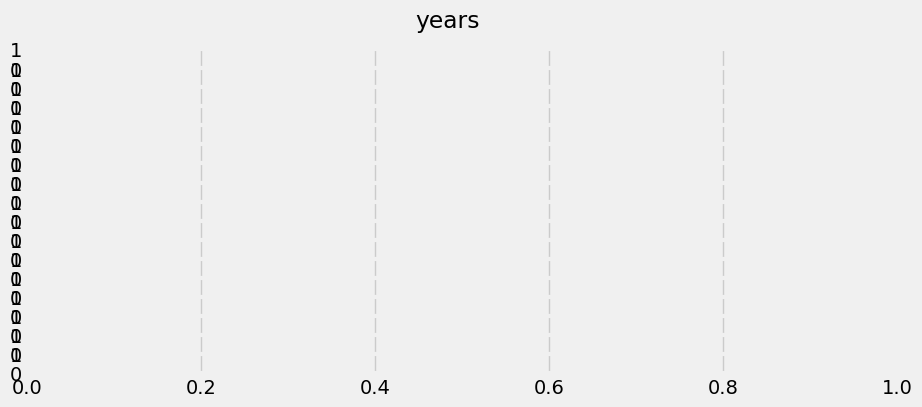

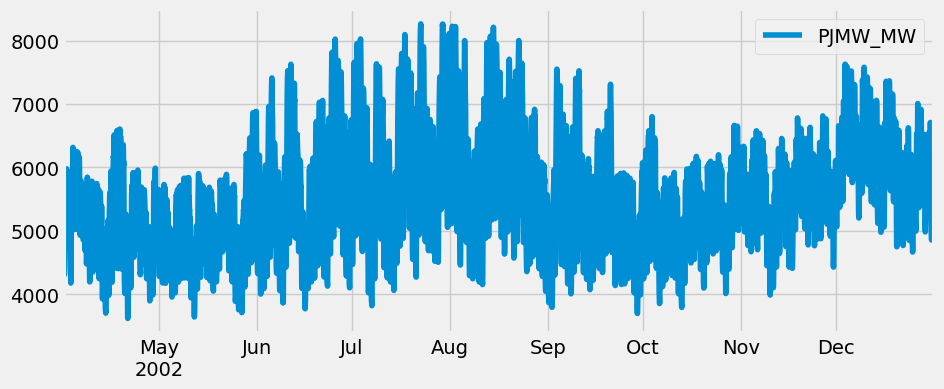

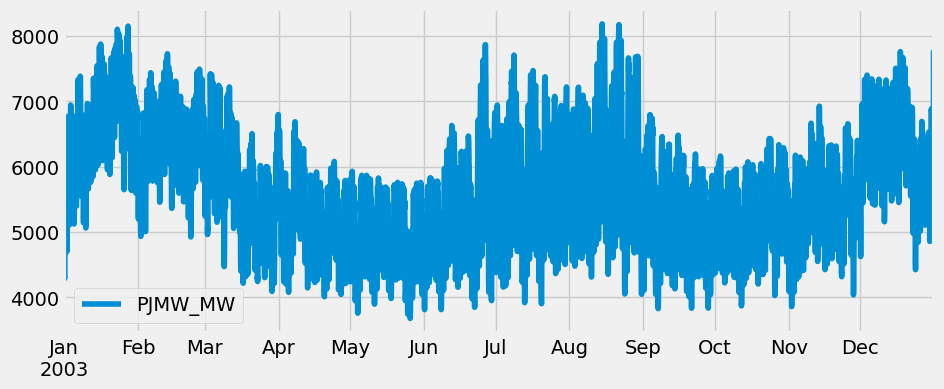

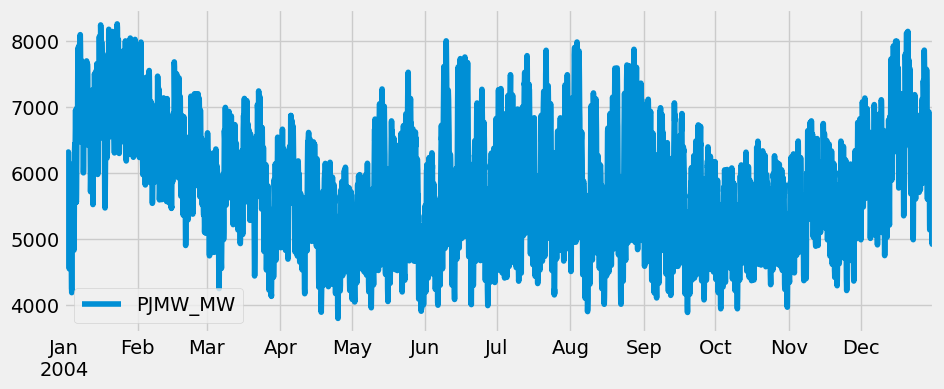

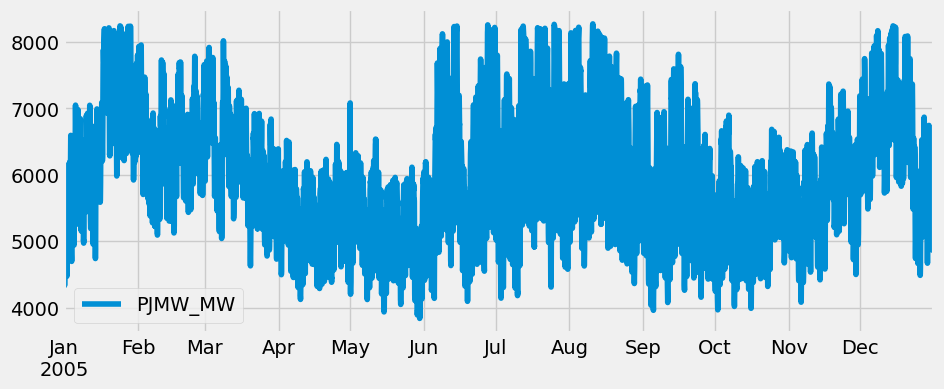

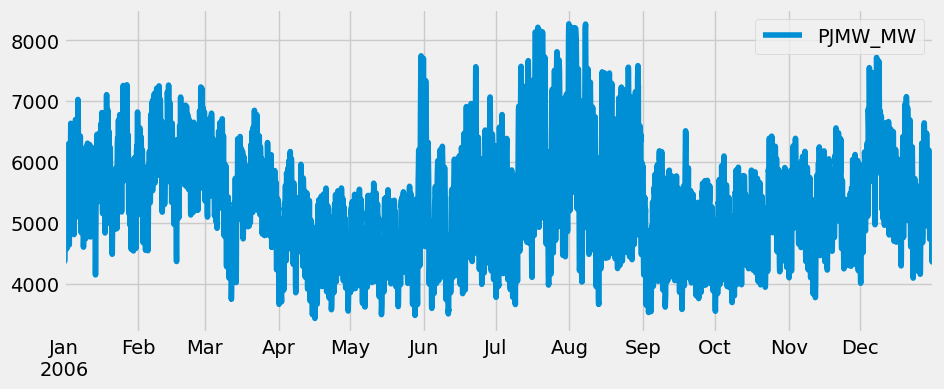

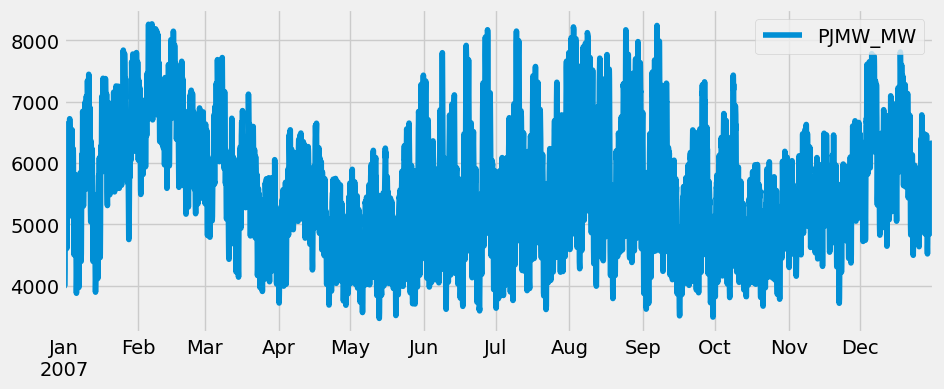

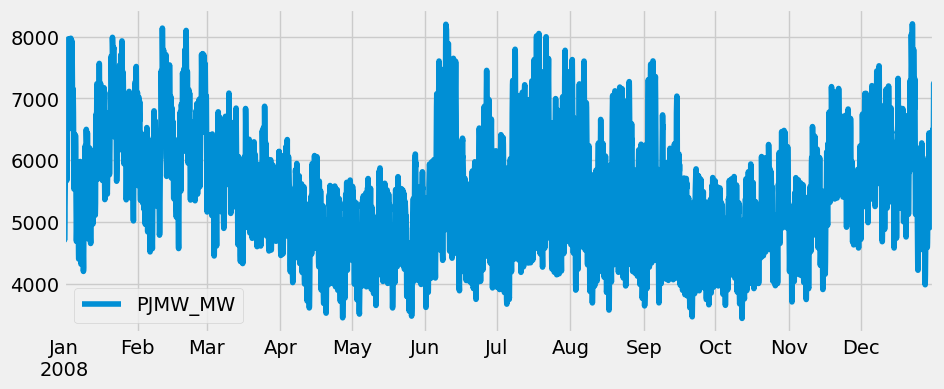

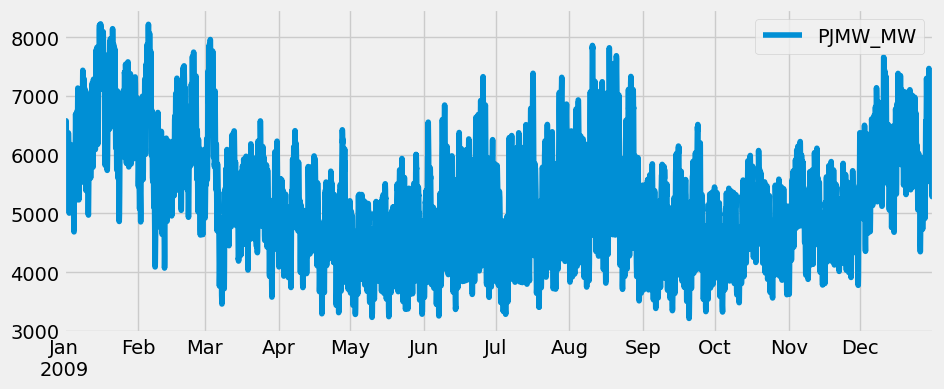

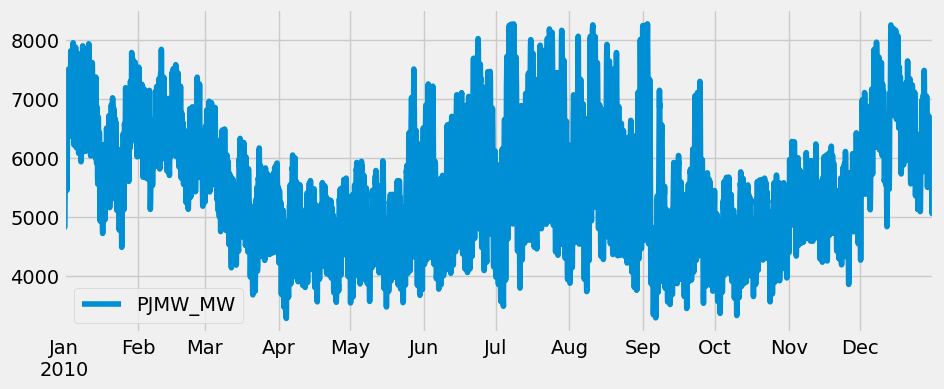

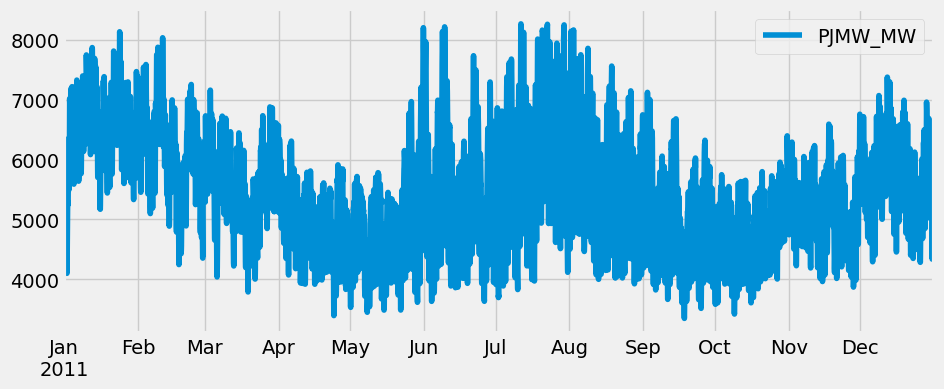

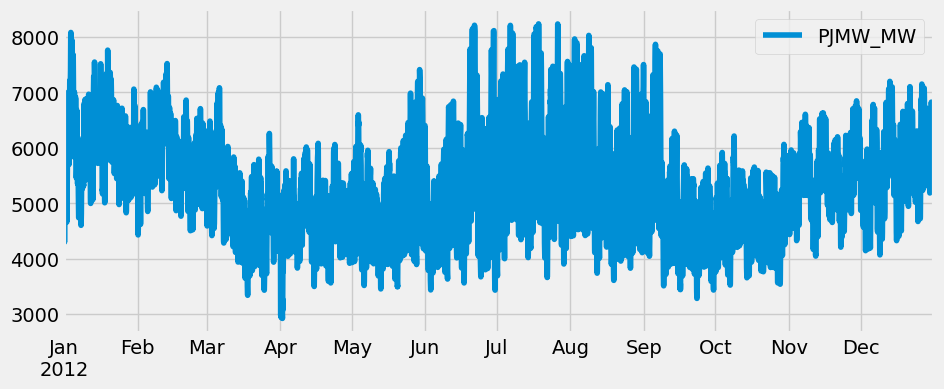

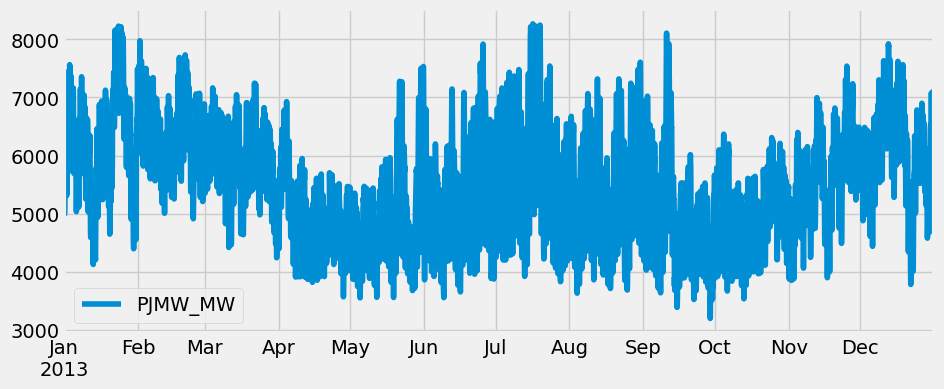

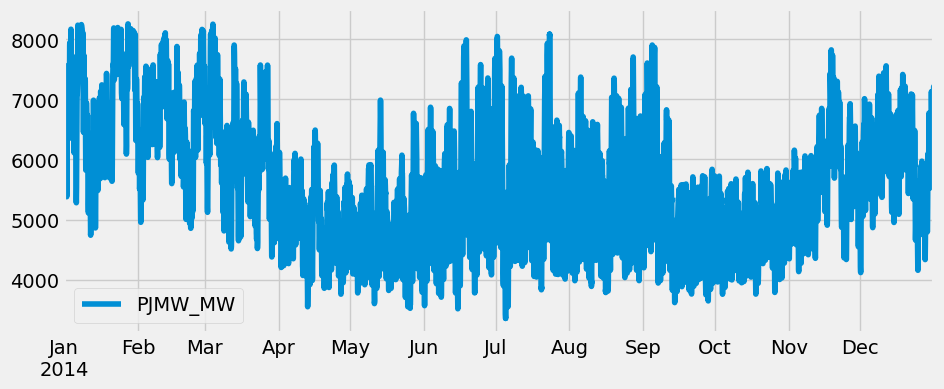

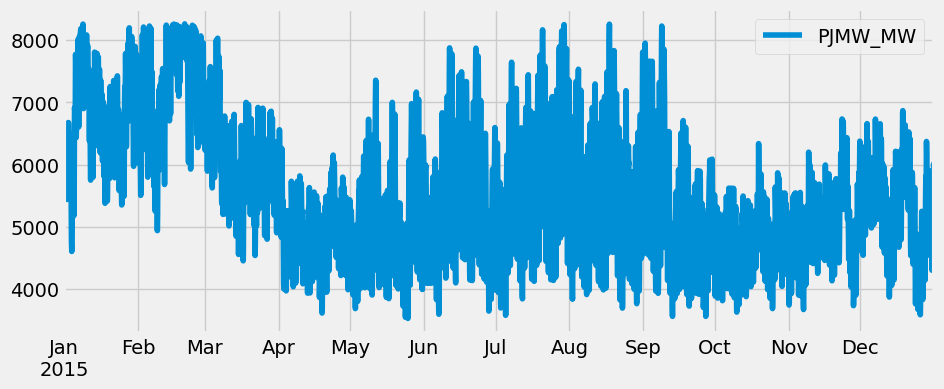

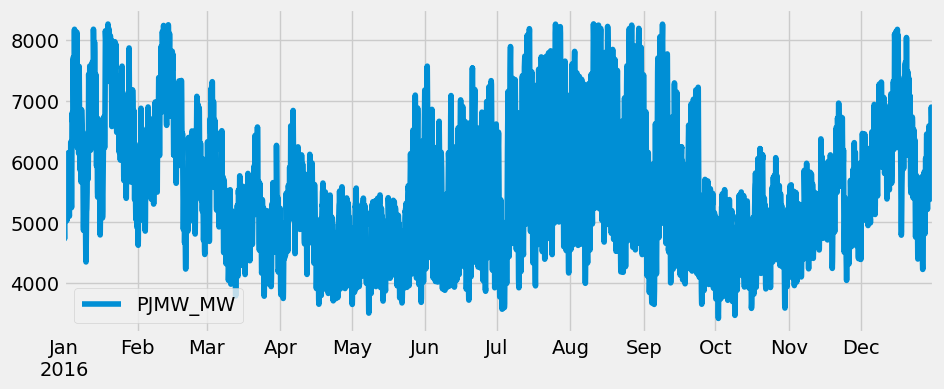

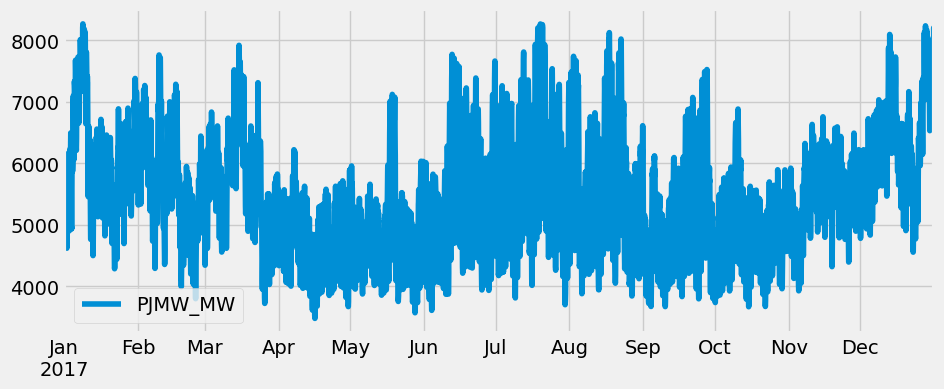

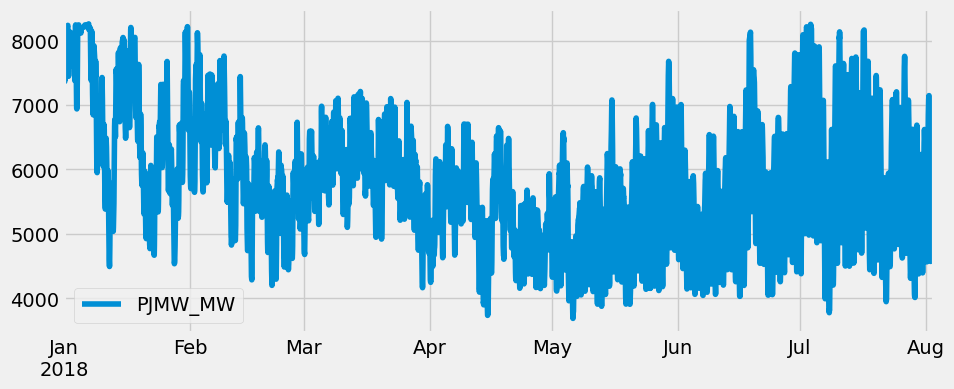

In [ ]:
fig = plt.figure()
gs = fig.add_gridspec(17, hspace=0)
axs = gs.subplots(sharex=True, sharey=True)
fig.suptitle('years')
df.loc['2002'].plot()
df.loc['2003'].plot()
df.loc['2004'].plot()
df.loc['2005'].plot()
df.loc['2006'].plot()
df.loc['2007'].plot()
df.loc['2008'].plot()
df.loc['2009'].plot()
df.loc['2010'].plot()
df.loc['2011'].plot()
df.loc['2012'].plot()
df.loc['2013'].plot()
df.loc['2014'].plot()
df.loc['2015'].plot()
df.loc['2016'].plot()
df.loc['2017'].plot()
df.loc['2018'].plot()


In [ ]:
df2.describe()

PJMW_MW
count  143232.000000
mean     5600.194949
std       973.012338
min      2922.000000
25%      4906.000000
50%      5530.000000
75%      6252.000000
max      8269.000000

In [ ]:
df3=df2.copy()

#### Create the column 'Season' to Check for the seasonal trend

In [ ]:
df3['season']=df3['month'].copy()

In [ ]:
df3['season']=df3['season'].map({'Jan':'Winter','Feb':'Winter','Mar':'Winter','Apr':'Spring','May':'Spring','Jun':'Spring','Aug':'Summer','Sep':'Summer','Jul':'Summer','Oct': 'Fall','Nov': 'Fall','Dec': 'Fall'})


In [ ]:
df3.head()

PJMW_MW month  year day Hour weekday_name  season
Datetime                                                              
2002-04-01 01:00:00   4374.0   Apr  2002  01   01       Monday  Spring
2002-04-01 02:00:00   4306.0   Apr  2002  01   02       Monday  Spring
2002-04-01 03:00:00   4322.0   Apr  2002  01   03       Monday  Spring
2002-04-01 04:00:00   4359.0   Apr  2002  01   04       Monday  Spring
2002-04-01 05:00:00   4436.0   Apr  2002  01   05       Monday  Spring

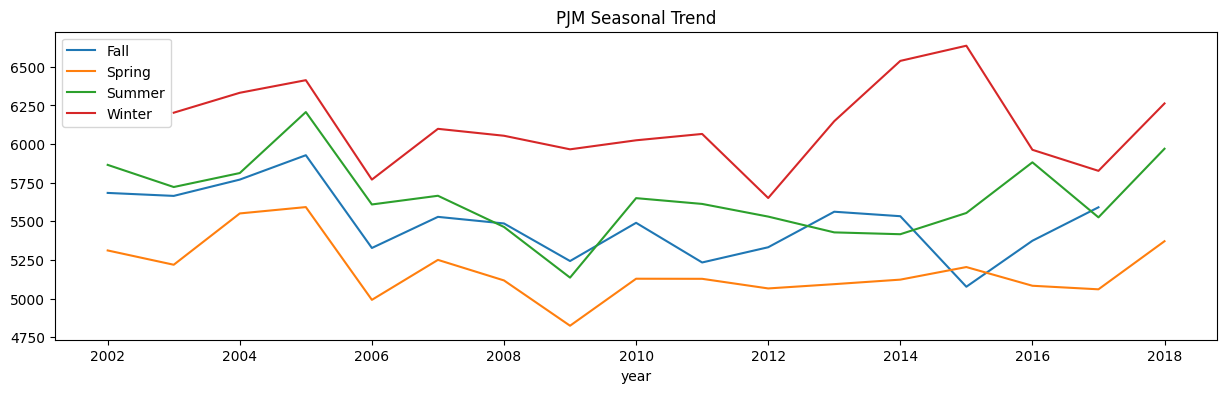

In [ ]:
df3.pivot_table(index=df3['year'], 
                     columns='season', 
                     values='PJMW_MW',
                     aggfunc='mean').plot(figsize=(15,4),
                     title='PJM Seasonal Trend')
plt.legend(loc='upper left')

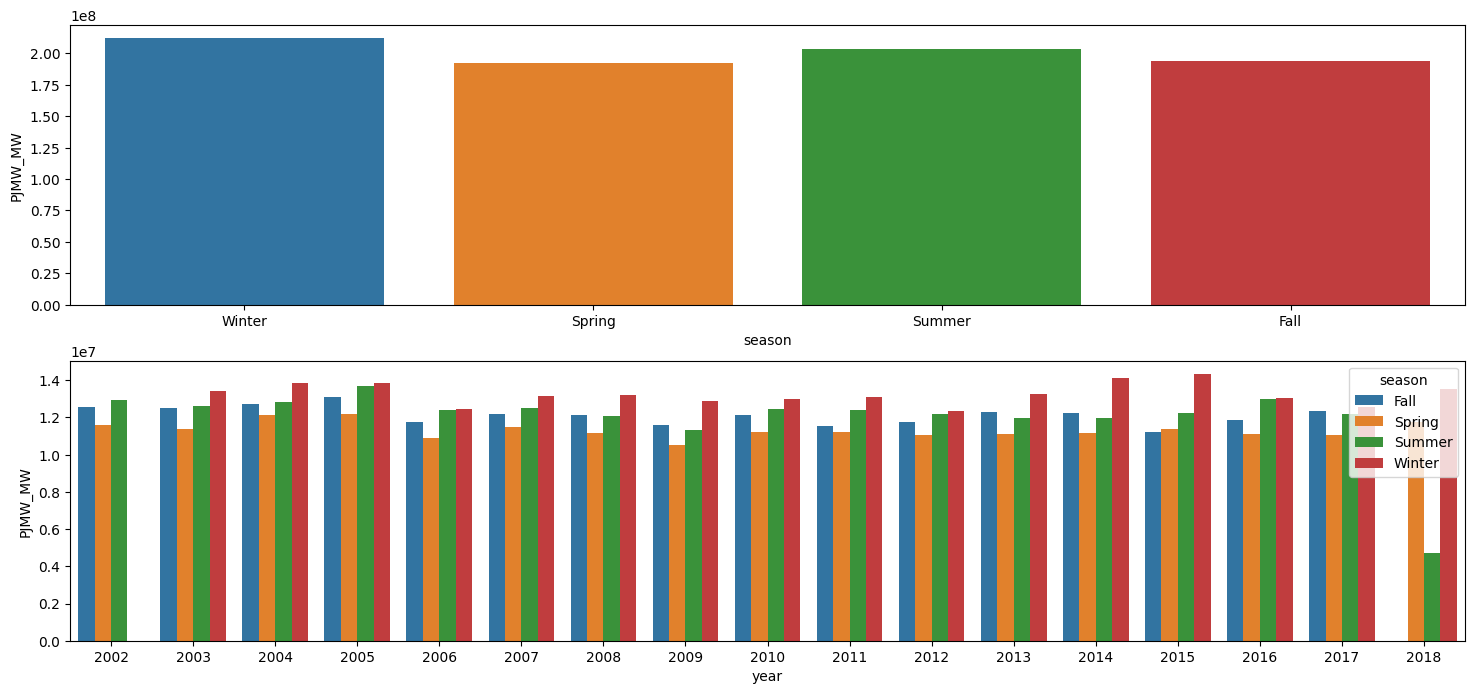

In [ ]:
plt.figure(figsize=(18,8))
aux1 = df3[['season', 'PJMW_MW']].groupby( 'season' ).sum().reset_index()
plt.subplot( 2, 1, 1 )
sns.barplot( x='season', y='PJMW_MW', data=aux1, order=['Winter', 'Spring', 'Summer', 'Fall'] )

aux2 = df3[['year', 'season', 'PJMW_MW']].groupby( ['year', 'season'] ).sum().reset_index()
plt.subplot( 2, 1, 2 )
sns.barplot( x='year', y='PJMW_MW', hue='season', data=aux2 );

Observation: For winter season the energy consumption is on a higher side and for spring the consumption is comparatively low

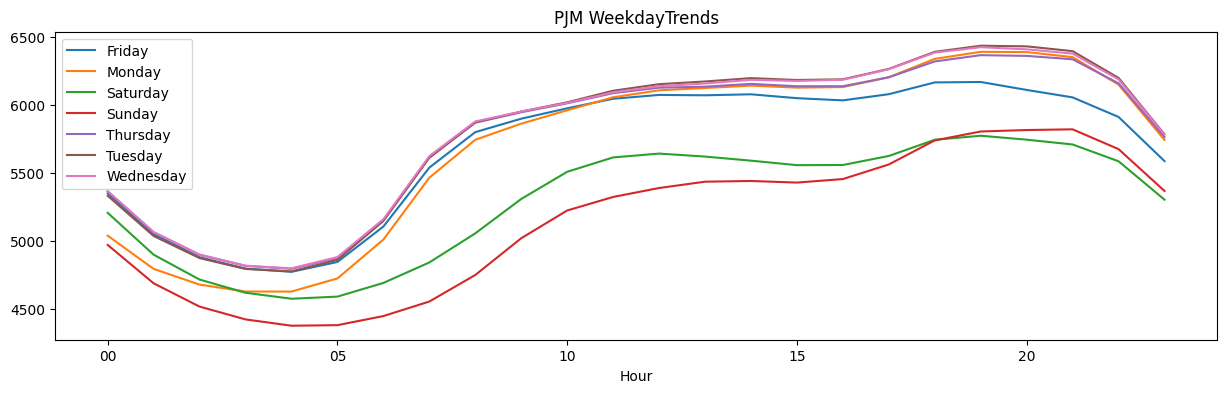

In [ ]:
df2.pivot_table(index=df2['Hour'], 
                     columns='weekday_name', 
                     values='PJMW_MW',
                     aggfunc='mean').plot(figsize=(15,4),
                     title='PJM WeekdayTrends')
plt.legend(loc='upper left')

Observation: The plot shows that there are less consumption of power during weekends as compared to weekdays. Also the power consumption began to rise from morning 7 and at midnight 10 it again decreases.

In [ ]:
df3['date'] = df3.index.date

In [ ]:
df4=df3.reset_index()


#### Check for the Holiday trend

In [ ]:
#import holidays
#df4['holidays'] = df4.date.apply( lambda x: 'Holiday' if x in holidays.US() else 'Normal day' )

In [ ]:
import holidays

us_holidays = holidays.US(years=2023) # Generate a list of US holidays for 2023

df4['holidays'] = df4.date.apply(lambda x: 'Holiday' if x in us_holidays else 'Normal day')


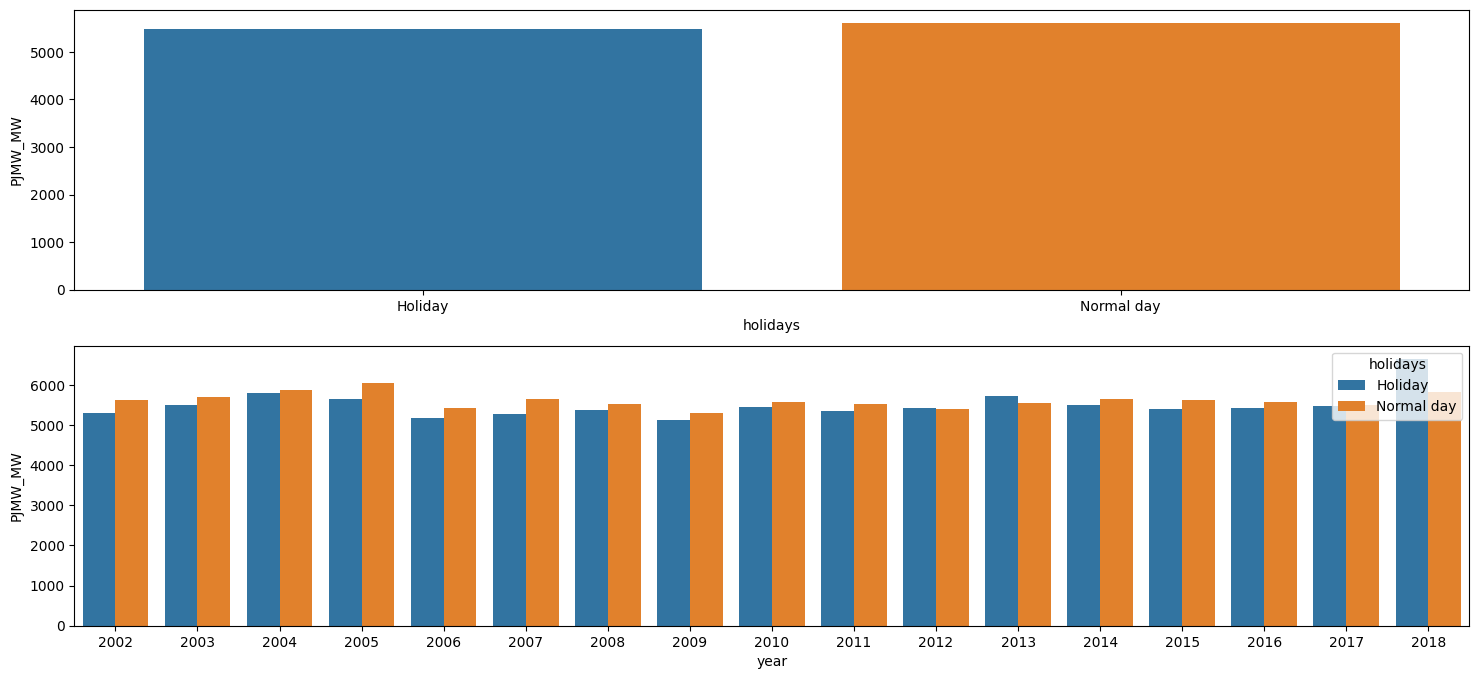

In [ ]:
plt.figure(figsize=(18,8))

aux1 = df4[['holidays', 'PJMW_MW']].groupby( 'holidays' ).mean().reset_index()
plt.subplot( 2, 1, 1 )
sns.barplot( x='holidays', y='PJMW_MW', data=aux1 )

aux2 = df4[['year', 'holidays', 'PJMW_MW']].groupby( ['year', 'holidays'] ).mean().reset_index()
plt.subplot( 2, 1, 2 )
sns.barplot( x='year', y='PJMW_MW', hue='holidays', data=aux2 );

## Decomposition
We will de-compose the time series into trend, seasonal and residuals

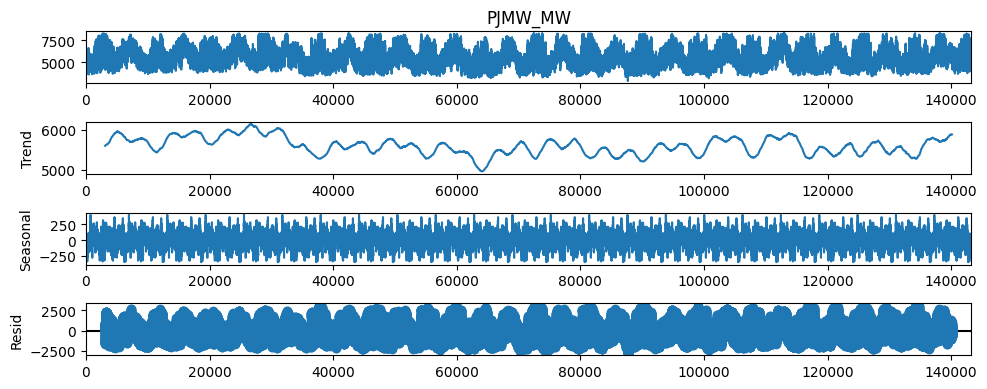

In [ ]:
decompose = seasonal_decompose(df4.PJMW_MW,period=6205)
decompose.plot()
plt.show()

This graph gives us an overall trend in our data from year 2002 till year 2018.
Seasonality cannot be checked as the datapoints are too many.

##### Lets resample and aggregate up to weekly level to reduce the noise

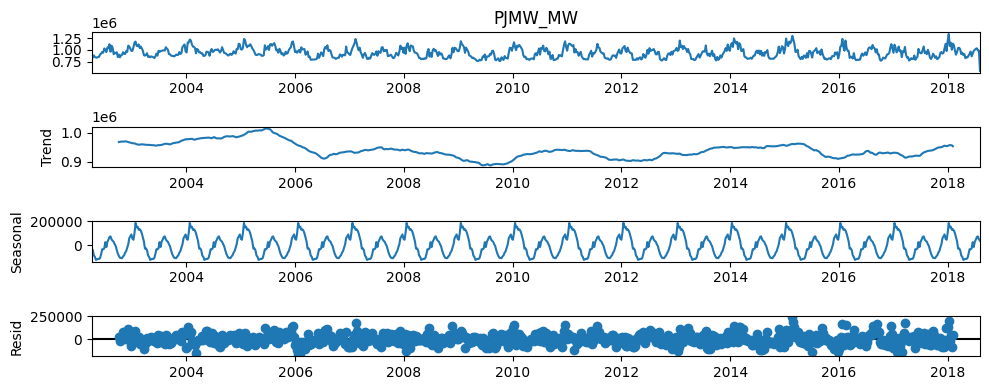

In [ ]:
plt.rcParams["figure.figsize"]= (10,4)
weekly_data = df2.PJMW_MW.resample(rule='W').sum()
decomposition = seasonal_decompose(weekly_data, model='additive') # Aggregate to weekly level
fig = decomposition.plot()
plt.show()

Observations:
There is no trend since its not increasing or decreasing.
Seasonal pattern is consistent
Resduals are whetever is left after fitting the trend and seasonal components to the observed data. It's the component we cannot explain. We want the residuals to be i.i.d (i.e uncorrelated). If the residuals have a pattern, it means there is still some structural information left to be captured. Residuals are showing some wavy pattern, which is not good. Let's perform **Ljung Box test** to confirm if they are i.i.d as a group.
We do not want to see any recognizable patterns in the residuals, e.g. waves, upward/downward slope, funnel pattern etc.

### Ljung Box test

In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox
acorr_ljungbox(df, lags=[1], return_df=True)

lb_stat  lb_pvalue
1  136065.907818        0.0

Since lb_pvalue < 0.05, residuals are uncorrelated. If the residuals are correlated, we can perform transformations to see if it stabilizes the variance. It's also an indication that we may need to use exogenous variable to fully explain the time series behaviour or use higher order models.
In this case, the residuals are uncorrelated.

#### LAG PLOT

A lag plot is used to help evaluate whether the values in a dataset or time series are random. If the data are random, the lag plot will exhibit no identifiable pattern. If the data are not random, the lag plot will demonstrate a clearly identifiable pattern

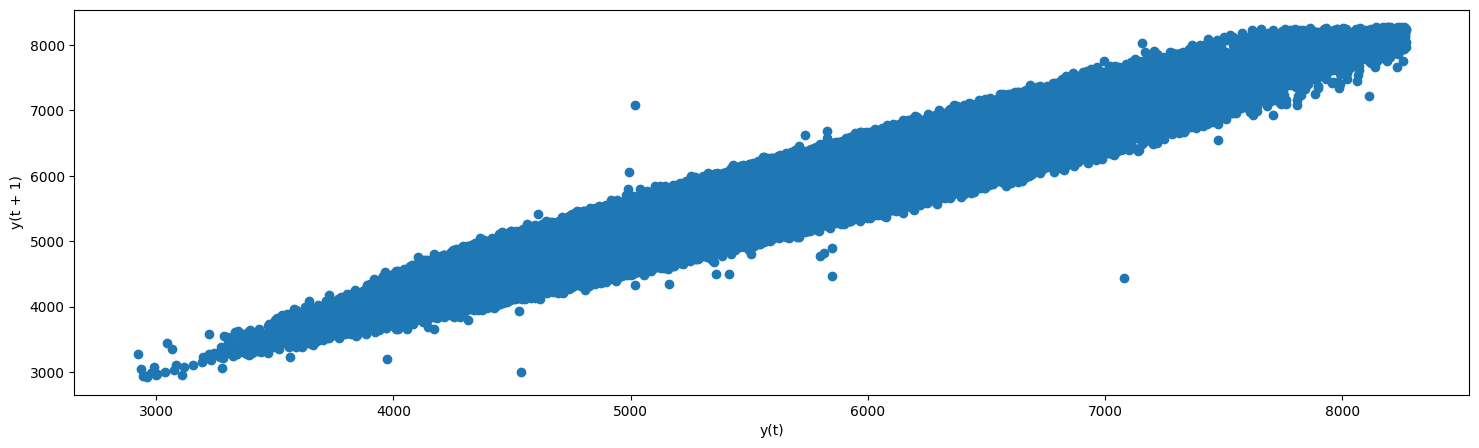

In [ ]:
from pandas.plotting import lag_plot
plt.figure(figsize=(18,5))
lag_plot(df2.PJMW_MW)
plt.show()

Our data has Moderate Autocorrelation as the lag plot is in eliptical shape.

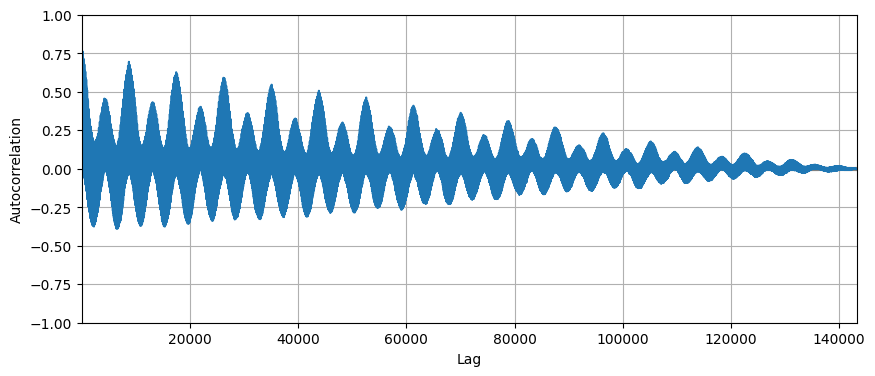

In [ ]:

from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df4.PJMW_MW)
plt.show()

#### Augmented Dickey-fuller test

In [ ]:
from statsmodels.tsa.stattools import adfuller
dftest = adfuller(df4.PJMW_MW , autolag= 'AIC')
print("1. ADF :" , dftest[0])
print("2. P-Value :" , dftest[1])
print("3. Num of lags :" , dftest[2])
print("4. No of obs used for ADF regression and critical value calculation :" , dftest[3])
print("5. Critical Values: ")
for key, val in dftest[4].items():
    print("\t",key, ": " , val)

1. ADF : -19.955595395550493
2. P-Value : 0.0
3. Num of lags : 74
4. No of obs used for ADF regression and critical value calculation : 143157
5. Critical Values: 
	 1% :  -3.4303956800384174
	 5% :  -2.861560189928386
	 10% :  -2.5667807463806995


Our p-value is definitely less than 0.05 and so we can say with pretty good confidence that we can reject the null (unit root, non-stationary data) and can assume our data is stationary.

### ACF & PACF Plot

/usr/local/lib/python3.9/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


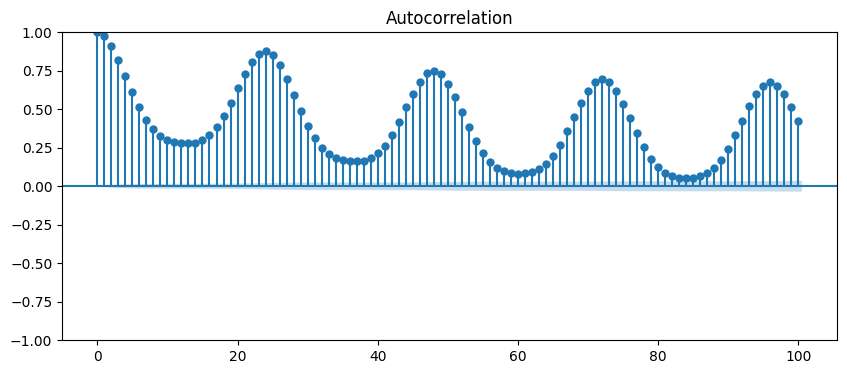

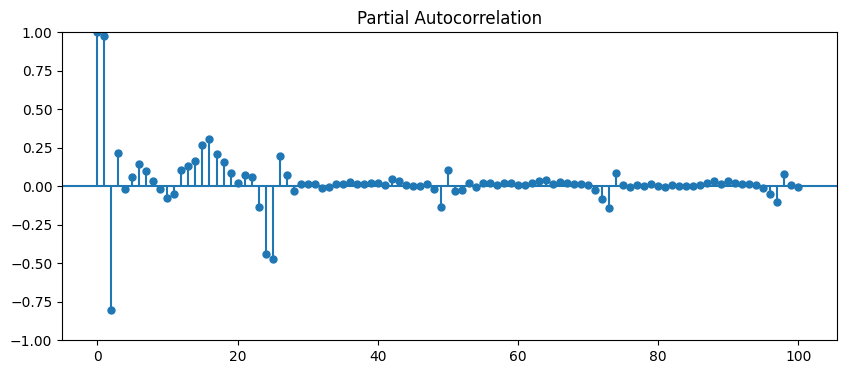

In [ ]:
tsa_plots.plot_acf(df4.PJMW_MW,lags=100)
tsa_plots.plot_pacf(df4.PJMW_MW,lags=100)
plt.show()

#### Downsample data to daily basis

In [ ]:
daily_data = df2.resample(rule='D').mean()
daily_data = daily_data.asfreq('D')

In [ ]:
daily_data.head(5)

PJMW_MW
Datetime               
2002-04-01  5271.173913
2002-04-02  5310.416667
2002-04-03  5325.916667
2002-04-04  5670.791667
2002-04-05  5686.125000

### Differencing the daily data to remove seasonality

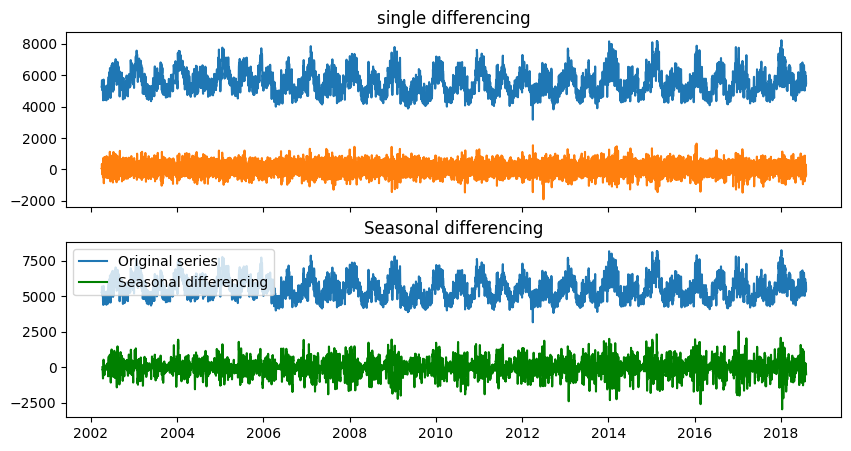

In [ ]:
fig, axes = plt.subplots(2,1,figsize=(10,5),dpi=100,sharex=True)
data=daily_data.PJMW_MW
axes[0].plot(data[:], label = "Original series")
axes[0].plot(data[:].diff(1), label = "single differencing")
axes[0].set_title("single differencing")
plt.legend(loc='upper left', fontsize=10)

#Second differencing with 7 lags

axes[1].plot(data[:], label = "Original series")
axes[1].plot(data[:].diff(7), label = "Seasonal differencing",color='green')
axes[1].set_title("Seasonal differencing")
plt.legend(loc='upper left', fontsize=10)

plt.show()

/usr/local/lib/python3.9/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


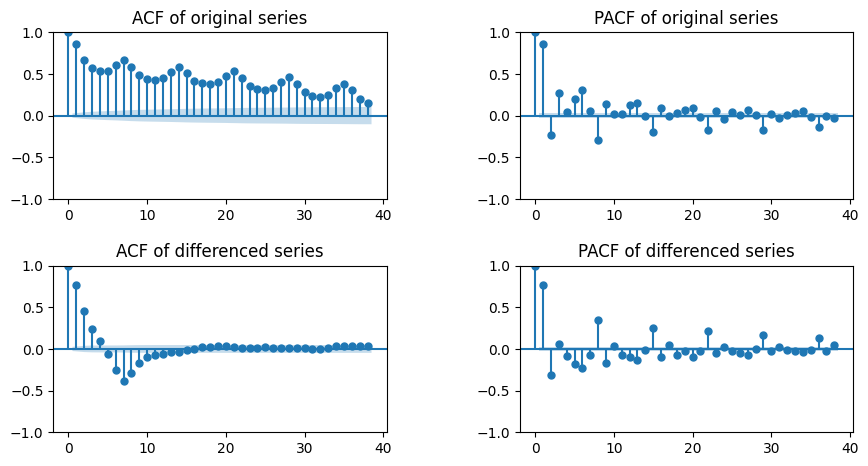

In [ ]:
fig,axes = plt.subplots(2,2,figsize=(10,5))
tsa_plots.plot_acf(daily_data, ax=axes[0,0]); axes[0,0].set_title('ACF of original series')
tsa_plots.plot_pacf(daily_data, ax=axes[0,1]); axes[0,1].set_title('PACF of original series')

#differencing
tsa_plots.plot_acf(daily_data.diff(7).dropna(), ax=axes[1,0]); axes[1,0].set_title('ACF of differenced series')
tsa_plots.plot_pacf(daily_data.diff(7).dropna(), ax=axes[1,1]); axes[1,1].set_title('PACF of differenced series')

plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.4,hspace=0.4)

### Double Differencing

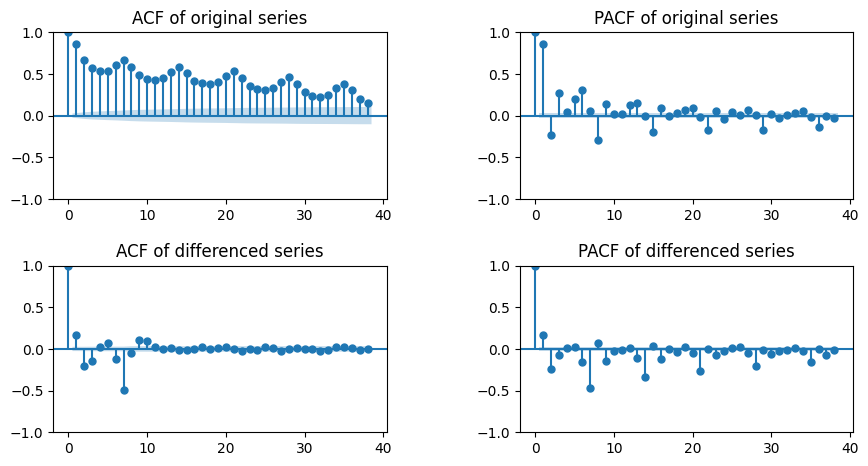

In [ ]:
fig,axes = plt.subplots(2,2,figsize=(10,5))
tsa_plots.plot_acf(daily_data, ax=axes[0,0]); axes[0,0].set_title('ACF of original series')
tsa_plots.plot_pacf(daily_data, ax=axes[0,1]); axes[0,1].set_title('PACF of original series')

#differencing
tsa_plots.plot_acf(daily_data.diff(7).diff().dropna(), ax=axes[1,0]); axes[1,0].set_title('ACF of differenced series')
tsa_plots.plot_pacf(daily_data.diff(7).diff().dropna(), ax=axes[1,1]); axes[1,1].set_title('PACF of differenced series')

plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.4,hspace=0.4)

# REGRESSION MODEL

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt

<Axes: >

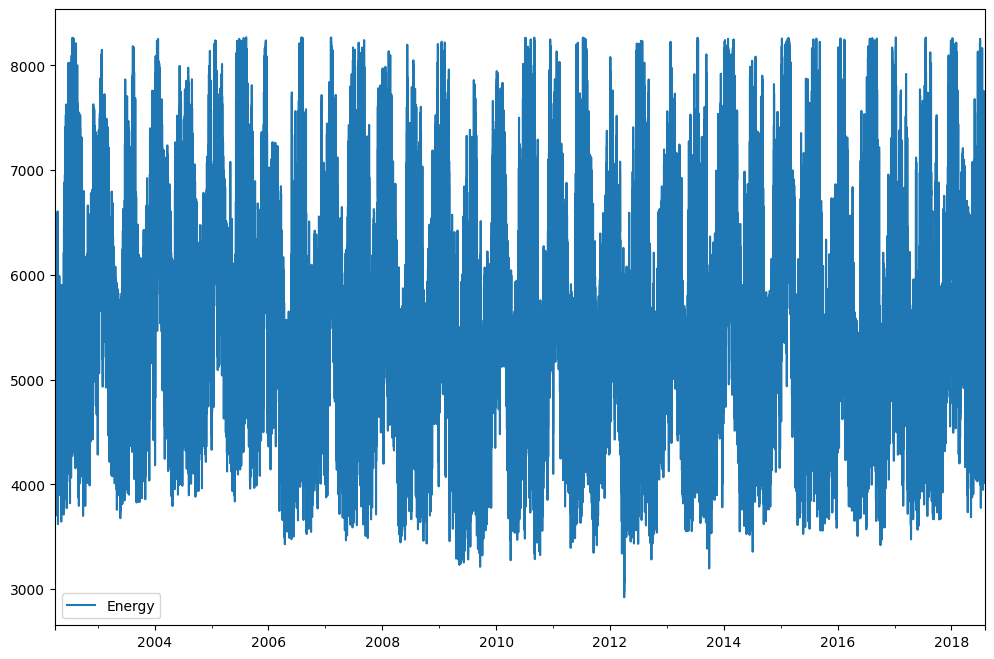

In [ ]:
df.columns = ['Energy']
df.plot(figsize=(12,8))

In [ ]:
daily_data = df.resample(rule='D').mean()
daily_data = daily_data.asfreq('D')

In [ ]:
daily_data

Energy
2002-04-01  5271.173913
2002-04-02  5310.416667
2002-04-03  5325.916667
2002-04-04  5670.791667
2002-04-05  5686.125000
...                 ...
2018-07-30  5492.708333
2018-07-31  5660.750000
2018-08-01  5959.708333
2018-08-02  5805.041667
2018-08-03  5489.000000

[5969 rows x 1 columns]

In [ ]:
daily_data1=daily_data.copy()

In [ ]:
daily_data['energy_1dayback']=daily_data['Energy'].shift(+1)
daily_data['energy_2dayback']=daily_data['Energy'].shift(+2)
daily_data['energy_3dayback']=daily_data['Energy'].shift(+3)
daily_data['energy_4dayback']=daily_data['Energy'].shift(+4)
daily_data['energy_5dayback']=daily_data['Energy'].shift(+5)
daily_data['energy_6dayback']=daily_data['Energy'].shift(+6)
daily_data['energy_7dayback']=daily_data['Energy'].shift(+7)

daily_data.head(10)

Energy  energy_1dayback  energy_2dayback  energy_3dayback  \
2002-04-01  5271.173913              NaN              NaN              NaN   
2002-04-02  5310.416667      5271.173913              NaN              NaN   
2002-04-03  5325.916667      5310.416667      5271.173913              NaN   
2002-04-04  5670.791667      5325.916667      5310.416667      5271.173913   
2002-04-05  5686.125000      5670.791667      5325.916667      5310.416667   
2002-04-06  5367.791667      5686.125000      5670.791667      5325.916667   
2002-04-07  5052.479167      5367.791667      5686.125000      5670.791667   
2002-04-08  5283.875000      5052.479167      5367.791667      5686.125000   
2002-04-09  5136.083333      5283.875000      5052.479167      5367.791667   
2002-04-10  5171.666667      5136.083333      5283.875000      5052.479167   

            energy_4dayback  energy_5dayback  energy_6dayback  energy_7dayback  
2002-04-01              NaN              NaN              NaN              NaN  
2002-04-02              NaN              NaN              NaN              NaN  
2002-04-03              NaN              NaN              NaN              NaN  
2002-04-04              NaN              NaN              NaN              NaN  
2002-04-05      5271.173913              NaN              NaN              NaN  
2002-04-06      5310.416667      5271.173913              NaN              NaN  
2002-04-07      5325.916667      5310.416667      5271.173913              NaN  
2002-04-08      5670.791667      5325.916667      5310.416667      5271.173913  
2002-04-09      5686.125000      5670.791667      5325.916667      5310.416667  
2002-04-10      5367.791667      5686.125000      5670.791667      5325.916667

In [ ]:
daily_data=daily_data.dropna()
daily_data

Energy  energy_1dayback  energy_2dayback  energy_3dayback  \
2002-04-08  5283.875000      5052.479167      5367.791667      5686.125000   
2002-04-09  5136.083333      5283.875000      5052.479167      5367.791667   
2002-04-10  5171.666667      5136.083333      5283.875000      5052.479167   
2002-04-11  5207.875000      5171.666667      5136.083333      5283.875000   
2002-04-12  5090.416667      5207.875000      5171.666667      5136.083333   
...                 ...              ...              ...              ...   
2018-07-30  5492.708333      5293.833333      5485.791667      5978.750000   
2018-07-31  5660.750000      5492.708333      5293.833333      5485.791667   
2018-08-01  5959.708333      5660.750000      5492.708333      5293.833333   
2018-08-02  5805.041667      5959.708333      5660.750000      5492.708333   
2018-08-03  5489.000000      5805.041667      5959.708333      5660.750000   

            energy_4dayback  energy_5dayback  energy_6dayback  energy_7dayback  
2002-04-08      5670.791667      5325.916667      5310.416667      5271.173913  
2002-04-09      5686.125000      5670.791667      5325.916667      5310.416667  
2002-04-10      5367.791667      5686.125000      5670.791667      5325.916667  
2002-04-11      5052.479167      5367.791667      5686.125000      5670.791667  
2002-04-12      5283.875000      5052.479167      5367.791667      5686.125000  
...                     ...              ...              ...              ...  
2018-07-30      6216.458333      6036.208333      6142.666667      5900.041667  
2018-07-31      5978.750000      6216.458333      6036.208333      6142.666667  
2018-08-01      5485.791667      5978.750000      6216.458333      6036.208333  
2018-08-02      5293.833333      5485.791667      5978.750000      6216.458333  
2018-08-03      5492.708333      5293.833333      5485.791667      5978.750000  

[5962 rows x 8 columns]

In [ ]:
daily_data1.to_csv('dataset_daily.csv')

In [ ]:
import numpy as np
x1,x2,x3,x4,x5,x6,x7,y=daily_data['energy_1dayback'],daily_data['energy_2dayback'],daily_data['energy_3dayback'],daily_data['energy_4dayback'],daily_data['energy_5dayback'],daily_data['energy_6dayback'],daily_data['energy_7dayback'],daily_data['Energy']
x1,x2,x3,x4,x5,x6,x7,y=np.array(x1),np.array(x2),np.array(x3),np.array(x4),np.array(x5),np.array(x6),np.array(x7),np.array(y)
x1,x2,x3,x4,x5,x6,x7,y=x1.reshape(-1,1),x2.reshape(-1,1),x3.reshape(-1,1),x4.reshape(-1,1),x5.reshape(-1,1),x6.reshape(-1,1),x7.reshape(-1,1),y.reshape(-1,1)
final_x=np.concatenate((x1,x2,x3,x4,x5,x6,x7),axis=1)
print(final_x)

[[5052.47916667 5367.79166667 5686.125      ... 5325.91666667
  5310.41666667 5271.17391304]
 [5283.875      5052.47916667 5367.79166667 ... 5670.79166667
  5325.91666667 5310.41666667]
 [5136.08333333 5283.875      5052.47916667 ... 5686.125
  5670.79166667 5325.91666667]
 ...
 [5660.75       5492.70833333 5293.83333333 ... 5978.75
  6216.45833333 6036.20833333]
 [5959.70833333 5660.75       5492.70833333 ... 5485.79166667
  5978.75       6216.45833333]
 [5805.04166667 5959.70833333 5660.75       ... 5293.83333333
  5485.79166667 5978.75      ]]


In [ ]:
final_x

array([[5052.47916667, 5367.79166667, 5686.125     , ..., 5325.91666667,
        5310.41666667, 5271.17391304],
       [5283.875     , 5052.47916667, 5367.79166667, ..., 5670.79166667,
        5325.91666667, 5310.41666667],
       [5136.08333333, 5283.875     , 5052.47916667, ..., 5686.125     ,
        5670.79166667, 5325.91666667],
       ...,
       [5660.75      , 5492.70833333, 5293.83333333, ..., 5978.75      ,
        6216.45833333, 6036.20833333],
       [5959.70833333, 5660.75      , 5492.70833333, ..., 5485.79166667,
        5978.75      , 6216.45833333],
       [5805.04166667, 5959.70833333, 5660.75      , ..., 5293.83333333,
        5485.79166667, 5978.75      ]])

In [ ]:
y

array([[5283.875     ],
       [5136.08333333],
       [5171.66666667],
       ...,
       [5959.70833333],
       [5805.04166667],
       [5489.        ]])

In [ ]:
X_train,X_test,y_train,y_test=final_x[:-360],final_x[-360:],y[:-360],y[-360:]


# LR, RF and XGB Model

In [ ]:
from sklearn.linear_model import LinearRegression
lin_model=LinearRegression()

In [ ]:
from sklearn.ensemble import RandomForestRegressor
ran_model=RandomForestRegressor(n_estimators=100,max_features=3, random_state=1)

In [ ]:
ran_model.fit(X_train,y_train)
lin_model.fit(X_train,y_train)


<ipython-input-269-d3e4e21d0a03>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  ran_model.fit(X_train,y_train)


LinearRegression()

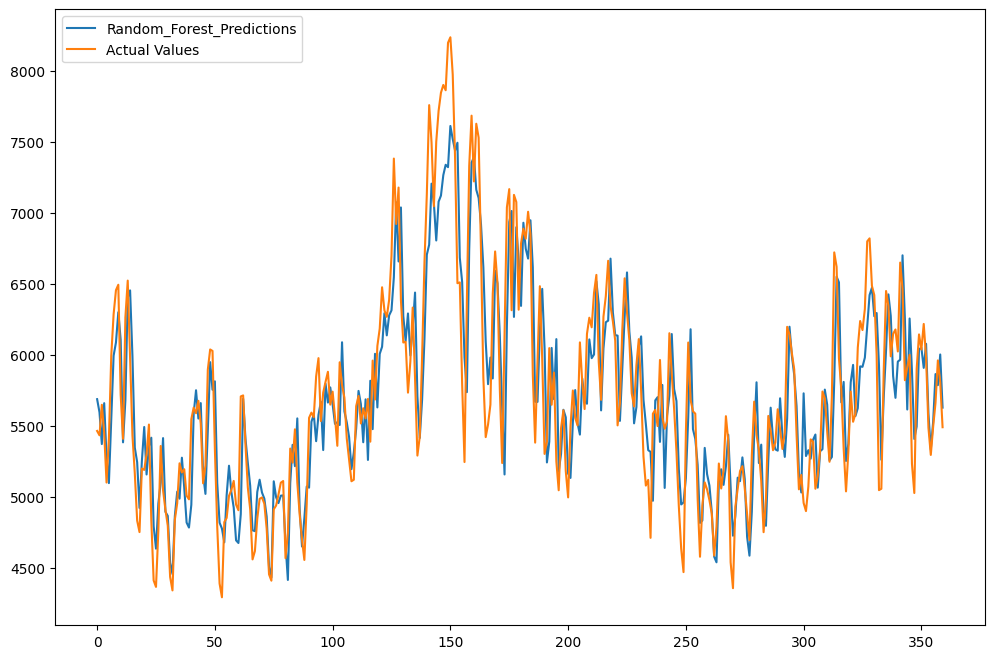

In [ ]:
ran_pred=ran_model.predict(X_test)
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,8)
plt.plot(ran_pred,label='Random_Forest_Predictions')
plt.plot(y_test,label='Actual Values')
plt.legend(loc="upper left")
plt.show()

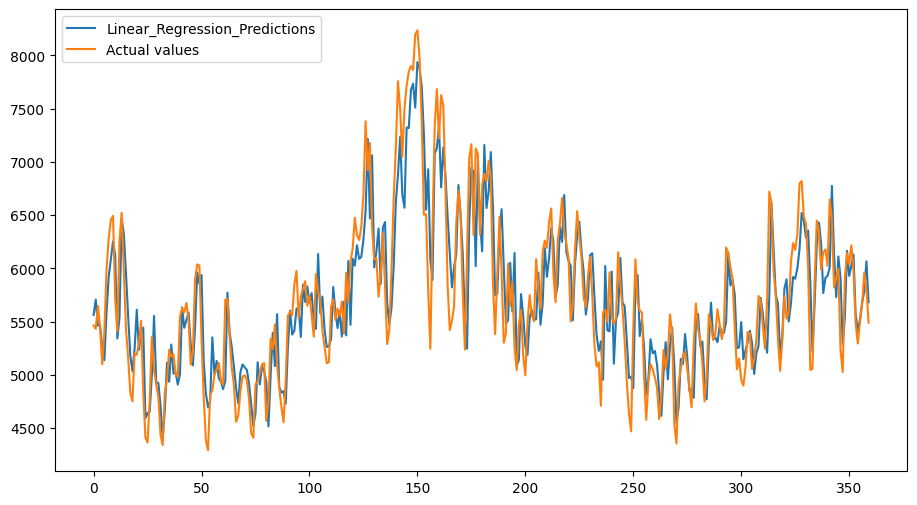

In [ ]:
lin_pred=lin_model.predict(X_test)
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (11,6)
plt.plot(lin_pred,label='Linear_Regression_Predictions')
plt.plot(y_test,label='Actual values')
plt.legend(loc="upper left")
plt.show()

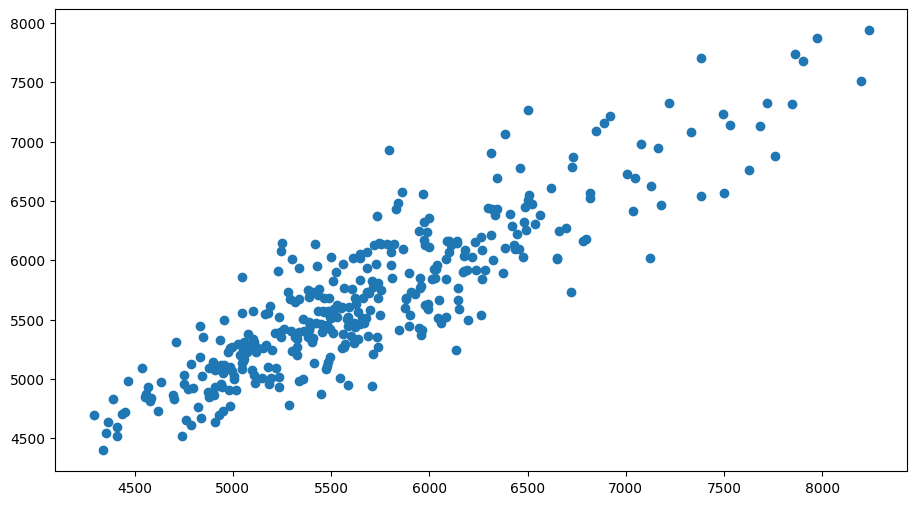

In [ ]:
plt.scatter(y_test,lin_pred)

In [ ]:
residual = y_test-lin_pred

<ipython-input-274-de15f7a7b687>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(residual)


<Axes: ylabel='Density'>

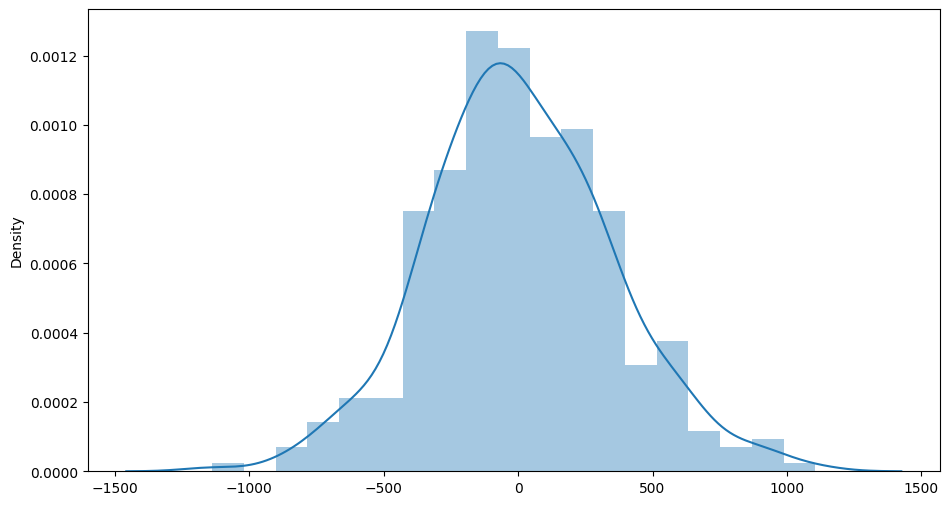

In [ ]:
sns.distplot(residual)

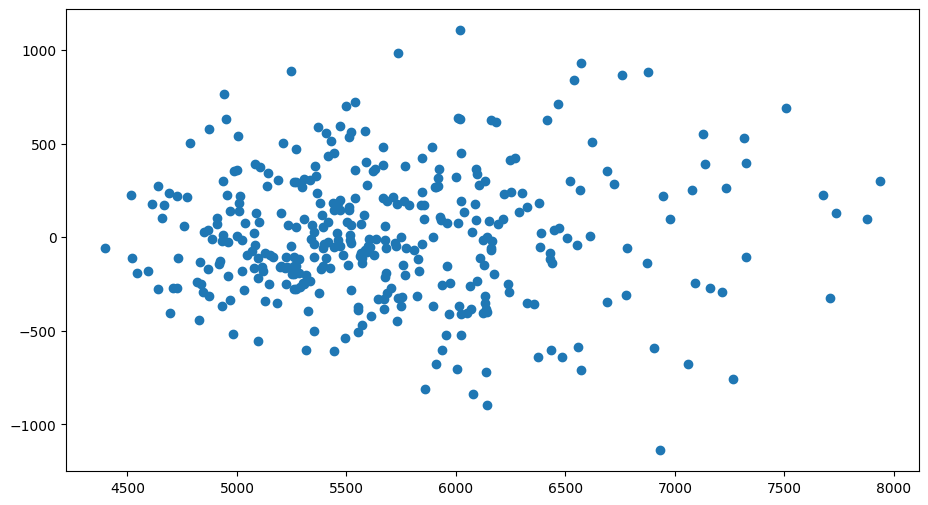

In [ ]:
plt.scatter(lin_pred,residual)

In [ ]:
from xgboost import XGBRegressor

In [ ]:
xg_model = XGBRegressor()

In [ ]:
xg_model.fit(X_train, y_train, verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [ ]:
predictions = xg_model.predict(X_test)

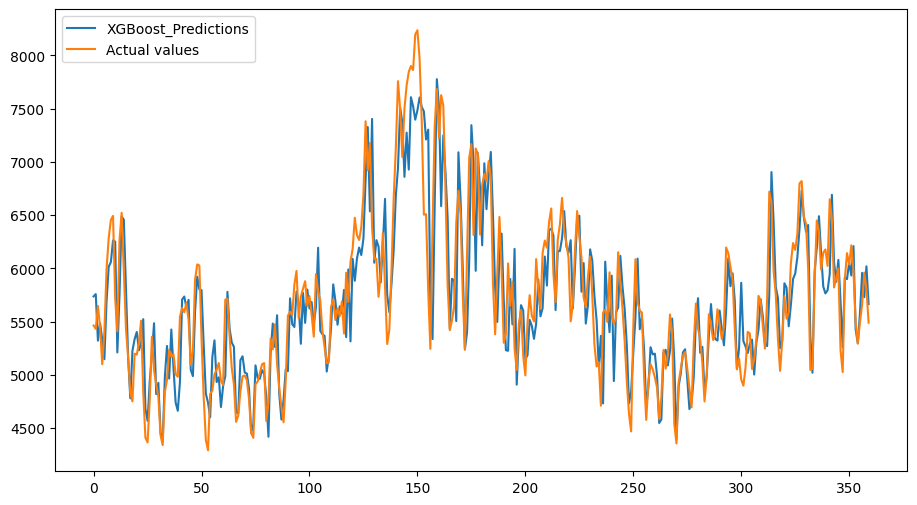

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (11,6)
plt.plot(predictions,label='XGBoost_Predictions')
plt.plot(y_test,label='Actual values')
plt.legend(loc="upper left")
plt.show()

# Calculate the RMSE,MAPE and MAE

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error , mean_absolute_percentage_error
from math import sqrt

RMSE_RF=sqrt(mean_squared_error(ran_pred,y_test))
RMSE_LR=sqrt(mean_squared_error(lin_pred,y_test))
MAE_RF = mean_absolute_error(ran_pred,y_test)
MAE_LR = mean_absolute_error(lin_pred,y_test)
MAPE_RF = round((mean_absolute_percentage_error(ran_pred,y_test)*100),3)
MAPE_LR = round((mean_absolute_percentage_error(lin_pred,y_test)*100),3)
MAE_XG = mean_absolute_error(y_test, predictions)
MAPE_XG= round((mean_absolute_percentage_error(y_test,predictions)*100),3)
RMSE_xg=sqrt(mean_squared_error(predictions,y_test))

In [ ]:
print('RMSE for Random Forest Model is:',RMSE_RF)
print('MAE for Random Forest Model is:',MAE_RF)
print('MAPE for Random Forest Model is:',MAPE_RF)


RMSE for Random Forest Model is: 349.1314378378216
MAE for Random Forest Model is: 273.9840516756102
MAPE for Random Forest Model is: 4.75


In [ ]:
print('RMSE for Linear Regression Model is:',RMSE_LR)
print('MAE for Linear Regression Model is:',MAE_LR)
print('MAPE for Linear Regression Model is:',MAPE_LR)

RMSE for Linear Regression Model is: 345.67300967045105
MAE for Linear Regression Model is: 270.70204107728046
MAPE for Linear Regression Model is: 4.719


In [ ]:
print('RMSE for XG Boost Model is:',RMSE_xg)
print('MAE for XG Boos Model is:',MAE_XG)
print('MAPE for XG Boos Model is:',MAPE_XG)

RMSE for XG Boost Model is: 360.19599311811726
MAE for XG Boos Model is: 272.596533203125
MAPE for XG Boos Model is: 4.694


## Calculate forecasting accuracy

### 1.LR Model

In [ ]:
from sklearn.linear_model import LinearRegression
final_lin_model=LinearRegression()

final_lin_model.fit(final_x,y)

LinearRegression()

In [ ]:
forecast_check_data = np.array(daily_data['Energy'][:'2018-07-04'][-7:])

In [ ]:
z=forecast_check_data

for i in range(0,30):
    ck=z[-7:]
    ck=np.array([ck])
    lin_f_chk=final_lin_model.predict(ck)
    z=np.append(z,lin_f_chk)
    i=+1
future_pred_lr=z[-30:]

In [ ]:
future_pred_lr

array([6083.28276851, 6218.950374  , 6136.2703283 , 6143.73069786,
       6517.1593167 , 6639.31826575, 6625.99061552, 6117.12025556,
       6242.08466537, 6118.19608775, 6055.02583408, 6337.10352403,
       6363.14321917, 6708.73406486, 6094.68902864, 6309.66387731,
       6096.83163052, 6004.87664591, 6291.19998298, 6020.98766026,
       6794.78189513, 5959.60376803, 6431.87611733, 6060.29716768,
       5939.28299584, 6407.02638149, 5589.78805411, 6989.21391043,
       5644.9337154 , 6636.96553047])

In [ ]:
future_chk = pd.date_range('2018-07-05','2018-08-03', freq='D')
future_chk_df = pd.DataFrame(index=future_chk)

In [ ]:
future_chk_df['future_chk_energy'] = future_pred_lr.tolist()

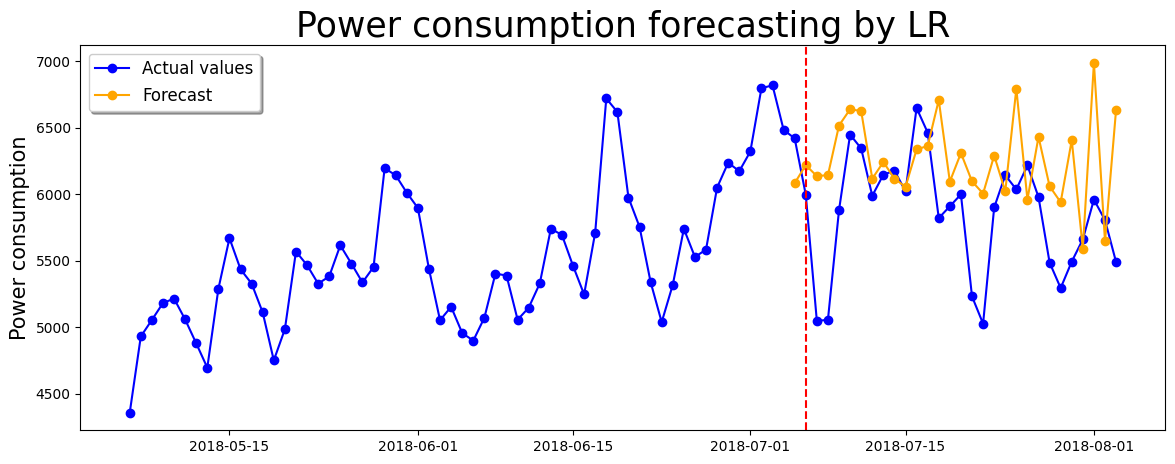

In [ ]:
plt.figure(figsize=(14,5))
plt.title("Power consumption forecasting by LR", fontsize=25)

plt.plot(daily_data1[-90:].index,daily_data1[-90:].values, label='Actual values', color="blue", marker="o")

plt.plot(future_chk_df.index,future_chk_df.values, label='Forecast', color="orange", marker="o")
# plt.fill_between(future_df.index, lower_limits_f, upper_limits_f, alpha=0.1, color="orange")

plt.axvline(future_chk_df.index[1], color="red", linestyle="--")
plt.legend(fontsize=12, fancybox=True, shadow=True, frameon=True)
plt.ylabel('Power consumption', fontsize=15)
plt.show()

In [ ]:
daily_data_last_30 = daily_data['Energy'].tail(30)

In [ ]:
MAE_check = mean_absolute_error(daily_data_last_30, future_chk_df)
MAPE_check= round((mean_absolute_percentage_error(daily_data_last_30,future_chk_df)*100),3)
RMSE_check=sqrt(mean_squared_error(future_chk_df,daily_data_last_30))


In [ ]:
print('RMSE for forecast check is:',RMSE_check)
print('MAE for forecast check is:',MAE_check)
print('MAPE for forecast check is:',MAPE_check)

RMSE for forecast check is: 600.8474368915226
MAE for forecast check is: 477.66419281578305
MAPE for forecast check is: 8.527


### 2.RF Model

In [ ]:
from sklearn.ensemble import RandomForestRegressor
final_RF_model=RandomForestRegressor(n_estimators=100,max_features=3, random_state=1)

In [ ]:
final_RF_model.fit(final_x,y)

<ipython-input-296-68e402cbcaa1>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  final_RF_model.fit(final_x,y)


RandomForestRegressor(max_features=3, random_state=1)

In [ ]:
z=forecast_check_data

for i in range(0,30):
    ck=z[-7:]
    ck=np.array([ck])
    rf_f_chk=final_RF_model.predict(ck)
    z=np.append(z,rf_f_chk)
    i=+1
future_pred_RF=z[-30:]

In [ ]:
future_pred_RF

array([5941.60291667, 6128.45354167, 6063.91583333, 6236.63791667,
       6571.86208333, 6738.98208333, 6482.49416667, 5907.52875   ,
       6258.79541667, 5982.4675    , 6036.59208333, 6206.40208333,
       6666.073125  , 6508.32041667, 5685.02041667, 6239.30583333,
       5869.03166667, 6000.37583333, 6011.48083333, 6530.42229167,
       6571.893125  , 5703.845     , 6334.08479167, 5640.38875   ,
       6097.58729167, 5652.41625   , 6264.73208333, 6620.37625   ,
       5657.18375   , 6364.36916667])

In [ ]:
future_chk_rf = pd.date_range('2018-07-05','2018-08-03', freq='D')
future_chk_df_rf = pd.DataFrame(index=future_chk_rf)
future_chk_df_rf['future_chk_energy'] = future_pred_RF.tolist()

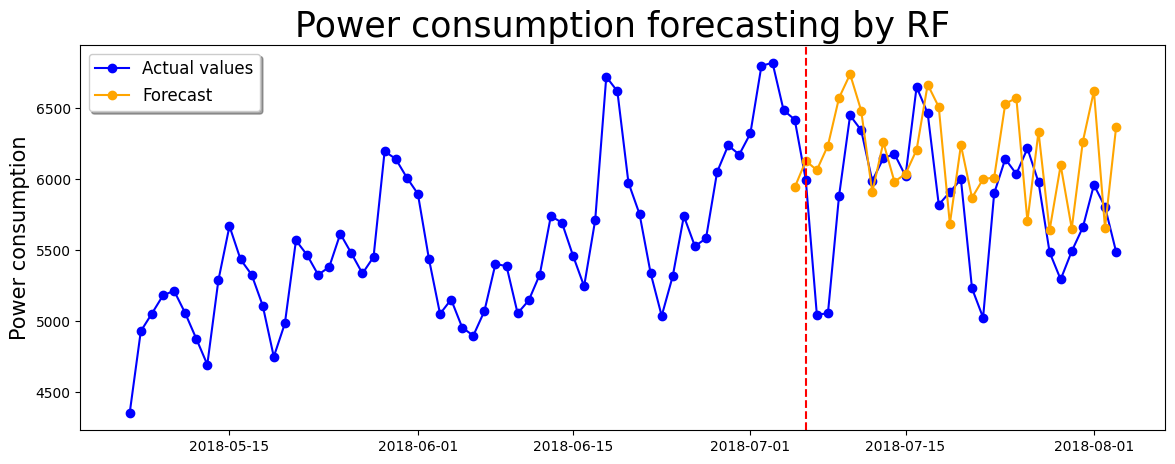

In [ ]:
plt.figure(figsize=(14,5))
plt.title("Power consumption forecasting by RF", fontsize=25)

plt.plot(daily_data1[-90:].index,daily_data1[-90:].values, label='Actual values', color="blue", marker="o")

plt.plot(future_chk_df_rf.index,future_chk_df_rf.values, label='Forecast', color="orange", marker="o")
# plt.fill_between(future_df.index, lower_limits_f, upper_limits_f, alpha=0.1, color="orange")

plt.axvline(future_chk_df_rf.index[1], color="red", linestyle="--")
plt.legend(fontsize=12, fancybox=True, shadow=True, frameon=True)
plt.ylabel('Power consumption', fontsize=15)
plt.show()

In [ ]:
MAE_rf_check = mean_absolute_error(daily_data_last_30, future_chk_df_rf)
MAPE_rf_check= round((mean_absolute_percentage_error(daily_data_last_30,future_chk_df_rf)*100),3)
RMSE_rf_check=sqrt(mean_squared_error(future_chk_df_rf,daily_data_last_30))
print('RMSE for RF forecast check is:',RMSE_rf_check)
print('MAE for RF forecast check is:',MAE_rf_check)
print('MAPE for RF forecast check is:',MAPE_rf_check)

RMSE for RF forecast check is: 535.9272074181981
MAE for RF forecast check is: 435.0305138888891
MAPE for RF forecast check is: 7.721


### 3.XGB Model

In [ ]:
from xgboost import XGBRegressor
final_xg_model = XGBRegressor()
final_xg_model.fit(final_x,y, verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [ ]:
z=forecast_check_data

for i in range(0,30):
    ck=z[-7:]
    ck=np.array([ck])
    xgb_f_chk=final_xg_model.predict(ck)
    z=np.append(z,xgb_f_chk)
    i=+1
future_pred_XGB=z[-30:]

In [ ]:
future_pred_XGB

array([6379.54785156, 6185.59765625, 6393.13037109, 6326.35058594,
       6632.80810547, 6806.88232422, 6529.63867188, 6447.86669922,
       6060.89501953, 6333.81201172, 6277.87792969, 6484.37255859,
       6655.18505859, 6471.06054688, 6464.79394531, 6025.65527344,
       6418.59326172, 6151.296875  , 6231.10205078, 6637.78125   ,
       6343.13818359, 6465.07763672, 5686.87353516, 6593.40234375,
       6180.08398438, 5880.19433594, 6750.26757812, 6128.46679688,
       6705.50390625, 5331.82177734])

In [ ]:
future_chk_xgb = pd.date_range('2018-07-05','2018-08-03', freq='D')
future_chk_df_xgb = pd.DataFrame(index=future_chk_xgb)
future_chk_df_xgb['future_chk_energy'] = future_pred_XGB.tolist()

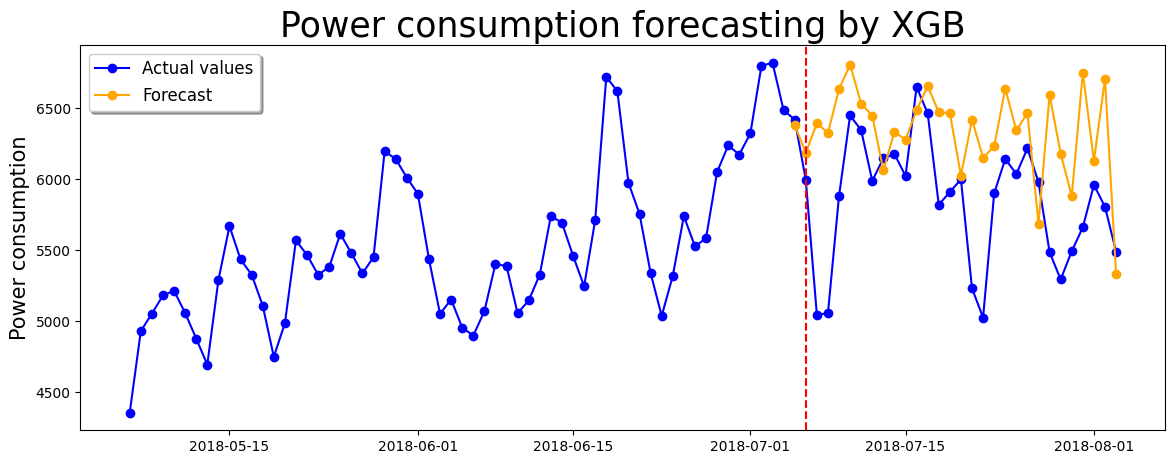

In [ ]:
plt.figure(figsize=(14,5))
plt.title("Power consumption forecasting by XGB", fontsize=25)

plt.plot(daily_data1[-90:].index,daily_data1[-90:].values, label='Actual values', color="blue", marker="o")

plt.plot(future_chk_df_xgb.index,future_chk_df_xgb.values, label='Forecast', color="orange", marker="o")
# plt.fill_between(future_df.index, lower_limits_f, upper_limits_f, alpha=0.1, color="orange")

plt.axvline(future_chk_df_xgb.index[1], color="red", linestyle="--")
plt.legend(fontsize=12, fancybox=True, shadow=True, frameon=True)
plt.ylabel('Power consumption', fontsize=15)
plt.show()

In [ ]:
MAE_xgb_check = mean_absolute_error(daily_data_last_30, future_chk_df_xgb)
MAPE_xgb_check= round((mean_absolute_percentage_error(daily_data_last_30,future_chk_df_xgb)*100),3)
RMSE_xgb_check=sqrt(mean_squared_error(future_chk_df_xgb,daily_data_last_30))
print('RMSE for XGB forecast check is:',RMSE_xgb_check)
print('MAE for XGB forecast check is:',MAE_xgb_check)
print('MAPE for XGB forecast check is:',MAPE_xgb_check)

RMSE for XGB forecast check is: 652.9352629327768
MAE for XGB forecast check is: 512.4949435763889
MAPE for XGB forecast check is: 9.213


## Forecast

In [ ]:
from sklearn.ensemble import RandomForestRegressor
final_RF_model=RandomForestRegressor(n_estimators=100,max_features=3, random_state=1)

In [ ]:
final_RF_model.fit(final_x,y)

<ipython-input-309-68e402cbcaa1>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  final_RF_model.fit(final_x,y)


RandomForestRegressor(max_features=3, random_state=1)

In [ ]:
daily_data_last_7 = np.array(daily_data['Energy'].tail(7))
daily_data_last_7

array([5485.79166667, 5293.83333333, 5492.70833333, 5660.75      ,
       5959.70833333, 5805.04166667, 5489.        ])

In [ ]:
np.savetxt("daily_data_last_7.csv", daily_data_last_7, delimiter=",")

In [ ]:
z=daily_data_last_7

for i in range(0,30):
    r=z[-7:]
    r=np.array([r])
    ranf_f=final_RF_model.predict(r)
    z=np.append(z,ranf_f)
    i=+1
future_pred=z[-30:]

In [ ]:
future_pred

array([5806.641875  , 5259.76375   , 5537.635     , 5484.3575    ,
       5925.08541667, 5813.82666667, 5525.17625   , 5993.02375   ,
       5240.30625   , 5829.85770833, 5285.35333333, 5882.60041667,
       5789.54333333, 5573.72833333, 6018.35666667, 5268.45958333,
       5902.31083333, 5162.69625   , 5813.850625  , 5829.92791667,
       5544.69916667, 6040.76958333, 5314.43166667, 5929.24166667,
       5117.87479167, 5666.37958333, 5711.47645833, 5524.9875    ,
       6012.54208333, 5291.24833333])

In [ ]:
future = pd.date_range('2018-08-04','2018-09-02', freq='D')
future_df = pd.DataFrame(index=future)

In [ ]:
future_df['future_energy'] = future_pred.tolist()

In [ ]:
print(future_df)

            future_energy
2018-08-04    5806.641875
2018-08-05    5259.763750
2018-08-06    5537.635000
2018-08-07    5484.357500
2018-08-08    5925.085417
2018-08-09    5813.826667
2018-08-10    5525.176250
2018-08-11    5993.023750
2018-08-12    5240.306250
2018-08-13    5829.857708
2018-08-14    5285.353333
2018-08-15    5882.600417
2018-08-16    5789.543333
2018-08-17    5573.728333
2018-08-18    6018.356667
2018-08-19    5268.459583
2018-08-20    5902.310833
2018-08-21    5162.696250
2018-08-22    5813.850625
2018-08-23    5829.927917
2018-08-24    5544.699167
2018-08-25    6040.769583
2018-08-26    5314.431667
2018-08-27    5929.241667
2018-08-28    5117.874792
2018-08-29    5666.379583
2018-08-30    5711.476458
2018-08-31    5524.987500
2018-09-01    6012.542083
2018-09-02    5291.248333


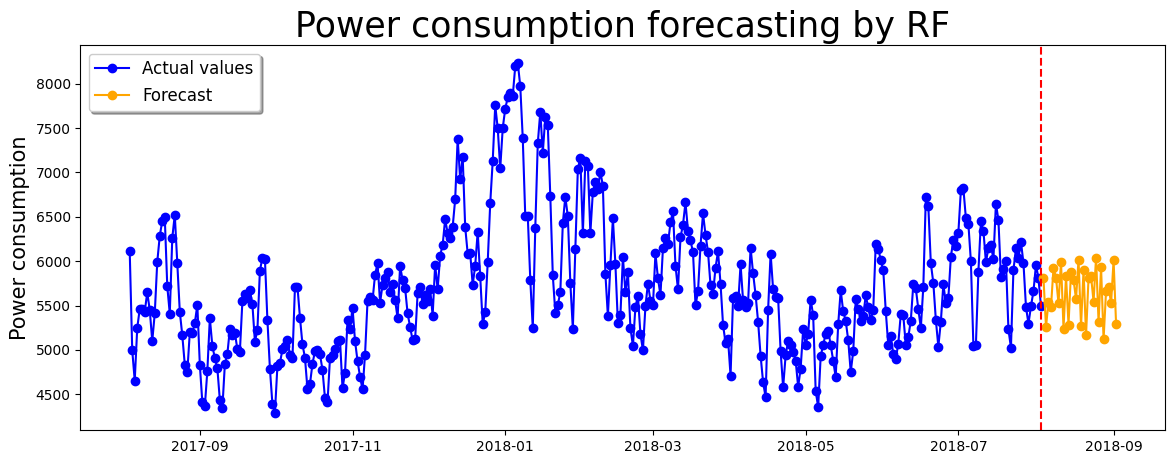

In [ ]:
plt.figure(figsize=(14,5))
plt.title("Power consumption forecasting by RF", fontsize=25)

plt.plot(daily_data1[-365:].index,daily_data1[-365:].values, label='Actual values', color="blue", marker="o")

plt.plot(future_df.index,future_df.values, label='Forecast', color="orange", marker="o")
# plt.fill_between(future_df.index, lower_limits_f, upper_limits_f, alpha=0.1, color="orange")

plt.axvline(daily_data1.index[-1], color="red", linestyle="--")
plt.legend(fontsize=12, fancybox=True, shadow=True, frameon=True)
plt.ylabel('Power consumption', fontsize=15)
plt.show()

## Saving the model

In [ ]:
# !pip install pickle-mixin

In [ ]:
import pickle

In [ ]:
filename = 'final_rf_model.pkl'
pickle.dump(final_RF_model, open(filename,'wb'))

In [ ]:
pickled_model=pickle.load(open('final_rf_model.pkl','rb'))

In [ ]:
pk=pickled_model.predict(X_test)